In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import HTML
import base64
import featuretools as ft
import os
print(os.listdir("../input"))
from sklearn.preprocessing import StandardScaler
# Any results you write to the current directory are saved as output.

['lgbm-fork-kernel-version', 'home-credit-default-risk', 'train-and-test-classifier']


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
plt.style.use('fivethirtyeight')
pd.options.mode.chained_assignment = None

In [3]:
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [6]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [7]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = reduce_mem_usage(pd.read_csv('../input/home-credit-default-risk/application_train.csv', nrows= num_rows))
    test_df = reduce_mem_usage(pd.read_csv('../input/home-credit-default-risk/application_test.csv', nrows= num_rows))
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_ANNUITY_TO_BIRTH_RATIO'] = (df['NEW_CREDIT_TO_ANNUITY_RATIO'] * 365) / df['DAYS_BIRTH'] #
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_ANNUITY_TO_GOODS_RATIO'] = df['AMT_ANNUITY'] / df['AMT_GOODS_PRICE'] #
    df['NEW_CREDIT_ANNUITY_TO_FAMILY_SIZE_RATIO'] = df['NEW_CREDIT_TO_ANNUITY_RATIO']/df['CNT_FAM_MEMBERS'] #
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
    df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
    df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
    df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / (1 + df['AMT_INCOME_TOTAL']) #
    df['NEW_INCOME_TO_BIRTH_RATIO'] = (1 + df['AMT_INCOME_TOTAL']) / df['DAYS_BIRTH'] #
    df['NEW_INCOME_TO_EMPLOY_RATIO'] = (1 + df['AMT_INCOME_TOTAL']) / df['DAYS_EMPLOYED'] #
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_CREDIT_ANNUITY_TO_EXT_SOURCES_RATIO'] = df['NEW_CREDIT_TO_ANNUITY_RATIO']/df['NEW_EXT_SOURCES_MEAN'] #
    df['NEW_EXT_SOURCES_MEAN_TO_BIRTH_RATIO'] = df['NEW_EXT_SOURCES_MEAN']/df['DAYS_BIRTH'] #
    df['NEW_EXT_SOURCES_MEAN_TO_EMPLOYED_RATIO'] = df['NEW_EXT_SOURCES_MEAN']/df['DAYS_EMPLOYED'] #
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_EMPLOY_RATIO'] = df['AMT_CREDIT'] / df['DAYS_EMPLOYED'] #
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'])
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    del test_df
    gc.collect()
    return df

In [8]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = reduce_mem_usage(pd.read_csv('../input/home-credit-default-risk/bureau.csv', nrows = num_rows))
    bb = reduce_mem_usage(pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv', nrows = num_rows))
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = active_agg.columns.tolist()
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    for e in cols:
        bureau_agg['NEW_RATIO_BURO_' + e[0] + "_" + e[1].upper()] = bureau_agg['ACTIVE_' + e[0] + "_" + e[1].upper()] / bureau_agg['CLOSED_' + e[0] + "_" + e[1].upper()]
    
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [9]:
def previous_applications(num_rows = None, nan_as_category = True):
    prev = reduce_mem_usage(pd.read_csv('../input/home-credit-default-risk/previous_application.csv', nrows = num_rows))
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': [ 'mean', 'var','std','max','min', 'sem'],
        'AMT_APPLICATION': [ 'mean', 'var','std','max','min', 'sem'],
        'AMT_CREDIT': [ 'mean', 'var','std','max','min', 'sem'],
        'APP_CREDIT_PERC': ['mean', 'var','std','max','min', 'sem'],
        'AMT_DOWN_PAYMENT': [ 'mean', 'var','std','max','min', 'sem'],
        'AMT_GOODS_PRICE': [ 'mean', 'var','std','max','min', 'sem'],
        'HOUR_APPR_PROCESS_START': [ 'mean', 'var','std','max','min', 'sem'],
        'RATE_DOWN_PAYMENT': [ 'mean', 'var','std','max','min', 'sem'],
        'DAYS_DECISION': [ 'mean', 'var','std','max','min', 'sem'],
        'CNT_PAYMENT': ['mean', 'var','std','max','min', 'sem', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean', 'var','std','max','min', 'sem']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = approved_agg.columns.tolist()
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    
    for e in cols:
        prev_agg['NEW_RATIO_PREV_' + e[0] + "_" + e[1].upper()] = prev_agg['APPROVED_' + e[0] + "_" + e[1].upper()] / prev_agg['REFUSED_' + e[0] + "_" + e[1].upper()]
    gc.collect()
    return prev_agg

In [10]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = reduce_mem_usage(pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv', nrows = num_rows))
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['mean', 'var','std','max','min', 'sem', 'size'],
        'SK_DPD': ['mean', 'var','std','max','min', 'sem'],
        'SK_DPD_DEF': ['mean', 'var','std','max','min', 'sem']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean', 'var','std','max','min', 'sem']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [11]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = reduce_mem_usage(pd.read_csv('../input/home-credit-default-risk/installments_payments.csv', nrows = num_rows))
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [12]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = reduce_mem_usage(pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv', nrows = num_rows))
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min','max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [13]:
def display_importances(feature_importance_df_, flag8):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    cols_to_save = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
    best_features_to_save = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols_to_save)]
    best_features_to_save.drop(columns='fold',inplace=True)
    best_features_to_save = best_features_to_save.groupby('feature')['importance'].mean().sort_values(ascending=False)[:200].reset_index()
    plt.figure(figsize=(16, 20))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    if flag8:
        plt.savefig('8_lgbm_importances.png')
        best_features_to_save.to_csv('8_feature_importance.csv', index=False)
    else:
        plt.savefig('92_lgbm_importances.png')
        best_features_to_save.to_csv('92_feature_importance.csv', index=False)

In [14]:
def display_shapley_values(feat_importance):
    best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean', 'std']) \
                                                               .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean shapley values", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean shapley values", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM shapley values (avg over folds)')
    plt.tight_layout()
    plt.show()

In [15]:
def GP2(data):
    v = pd.DataFrame()
    v["gp2_0"] = 0.010000*np.tanh(((((((((np.tanh((data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"]))) - (((np.where((((data["NEW_EXT_SOURCES_MEAN"]) < (data["NEW_DOC_IND_AVG"]))*1.)>0, ((data["NEW_EXT_SOURCES_MEAN"]) * 2.0), data["NEW_EXT_SOURCES_MEAN"] )) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp2_1"] = 0.034000*np.tanh((-1.0*((((((((((((((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)) - (np.where(np.maximum(((data["CC_CNT_DRAWINGS_ATM_CURRENT_VAR"])), ((data["NEW_EXT_SOURCES_MEAN"])))>0, data["CC_CNT_DRAWINGS_ATM_CURRENT_VAR"], data["NAME_INCOME_TYPE_Working"] )))) * 2.0)) * 2.0)) * 2.0)) * 2.0))))) 
    v["gp2_2"] = 0.048500*np.tanh(((data["OCCUPATION_TYPE_Drivers"]) + (((data["FLAG_DOCUMENT_3"]) + (((((data["NEW_EXT_SOURCES_MEAN"]) + (((np.tanh((data["CC_AMT_TOTAL_RECEIVABLE_MEAN"]))) + ((((((-1.0*((data["NEW_EXT_SOURCES_MEAN"])))) * 2.0)) * 2.0)))))) * 2.0)))))) 
    v["gp2_3"] = 0.030000*np.tanh(((((((((((data["NEW_CREDIT_TO_GOODS_RATIO"]) - ((-1.0*((np.tanh((data["CC_AMT_DRAWINGS_ATM_CURRENT_VAR"])))))))) - (((((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)) * 2.0)))) - (data["CODE_GENDER"]))) * 2.0)) * 2.0)) 
    v["gp2_4"] = 0.049000*np.tanh(((((((((((np.tanh((((np.tanh((data["DAYS_EMPLOYED"]))) - (data["EXT_SOURCE_3"]))))) - ((((data["EXT_SOURCE_2"]) < (data["NAME_EDUCATION_TYPE_Higher_education"]))*1.)))) - (data["EXT_SOURCE_2"]))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp2_5"] = 0.017800*np.tanh((((((((-1.0*((((data["NEW_EXT_SOURCES_MEAN"]) * 2.0))))) + (((data["NEW_CREDIT_TO_GOODS_RATIO"]) + ((((-1.0*((np.maximum(((data["CODE_GENDER"])), ((data["APPROVED_APP_CREDIT_PERC_MAX"]))))))) - (data["NEW_EXT_SOURCES_MEAN"]))))))) * 2.0)) * 2.0)) 
    v["gp2_6"] = 0.029394*np.tanh(((((((((((np.tanh((data["NEW_CREDIT_TO_GOODS_RATIO"]))) - (data["NEW_EXT_SOURCES_MEAN"]))) - (((((((data["NEW_EXT_SOURCES_MEAN"]) > (data["DAYS_EMPLOYED"]))*1.)) > (data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]))*1.)))) - (data["NEW_EXT_SOURCES_MEAN"]))) * 2.0)) * 2.0)) 
    v["gp2_7"] = 0.035000*np.tanh(((((((((np.tanh(((((data["DAYS_EMPLOYED"]) + (((np.tanh((((data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]) + (data["PREV_NAME_PRODUCT_TYPE_walk_in_MEAN"]))))) + (data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]))))/2.0)))) - (data["NEW_EXT_SOURCES_MEAN"]))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp2_8"] = 0.034200*np.tanh(((((np.minimum((((((((((-1.0*((data["NEW_EXT_SOURCES_MEAN"])))) * 2.0)) + (data["NEW_CREDIT_TO_GOODS_RATIO"]))) * 2.0))), (((((((-1.0*((data["NEW_EXT_SOURCES_MEAN"])))) - (data["APPROVED_AMT_DOWN_PAYMENT_MAX"]))) * 2.0))))) * 2.0)) * 2.0)) 
    v["gp2_9"] = 0.030000*np.tanh(((((((np.maximum(((np.minimum(((data["NAME_EDUCATION_TYPE_Secondary___secondary_special"])), ((np.tanh((data["DAYS_EMPLOYED"]))))))), ((((np.tanh((data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"]))) * 2.0))))) + (data["NEW_CREDIT_TO_GOODS_RATIO"]))) - (((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)))) * 2.0)) 
    v["gp2_10"] = 0.041000*np.tanh(((((((((((np.tanh((((data["NEW_CREDIT_TO_GOODS_RATIO"]) + (data["DAYS_EMPLOYED"]))))) - (data["EXT_SOURCE_2"]))) - (np.tanh((data["EXT_SOURCE_3"]))))) * 2.0)) + (np.tanh((data["REFUSED_DAYS_DECISION_MAX"]))))) * 2.0)) 
    v["gp2_11"] = 0.049000*np.tanh(((((((((np.tanh((data["CC_AMT_INST_MIN_REGULARITY_MEAN"]))) - (((data["APPROVED_APP_CREDIT_PERC_MAX"]) - (data["PREV_NAME_CLIENT_TYPE_New_MEAN"]))))) - (((data["APPROVED_AMT_CREDIT_MIN"]) - (data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]))))) - (data["NEW_EXT_SOURCES_MEAN"]))) - (data["NEW_EXT_SOURCES_MEAN"]))) 
    v["gp2_12"] = 0.049901*np.tanh(((((((((np.maximum(((data["NEW_CREDIT_TO_GOODS_RATIO"])), ((data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"])))) + (data["DEF_30_CNT_SOCIAL_CIRCLE"]))) + (np.tanh((data["CC_CNT_DRAWINGS_CURRENT_MAX"]))))) - (((data["CODE_GENDER"]) + (((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)))))) * 2.0)) 
    v["gp2_13"] = 0.049040*np.tanh(((((((np.maximum(((np.tanh((data["PREV_CNT_PAYMENT_MEAN"])))), ((data["CC_CNT_DRAWINGS_CURRENT_MAX"])))) + (((np.minimum(((data["NAME_EDUCATION_TYPE_Secondary___secondary_special"])), ((np.tanh((data["DAYS_EMPLOYED"])))))) - (((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)))))) * 2.0)) * 2.0)) 
    v["gp2_14"] = 0.044680*np.tanh(((((data["NEW_DOC_IND_KURT"]) + (data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]))) + (((((((((((data["DAYS_EMPLOYED"]) + (data["INSTAL_PAYMENT_DIFF_MAX"]))) - (data["EXT_SOURCE_2"]))) * 2.0)) - (data["PREV_RATE_DOWN_PAYMENT_MAX"]))) - (data["PREV_AMT_ANNUITY_MEAN"]))))) 
    v["gp2_15"] = 0.047043*np.tanh(((((((((np.tanh((np.where(data["PREV_APP_CREDIT_PERC_MEAN"]>0, data["CC_CNT_DRAWINGS_ATM_CURRENT_VAR"], ((data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]) + ((-1.0*((data["EXT_SOURCE_3"]))))) )))) + ((-1.0*((data["NEW_EXT_SOURCES_MEAN"])))))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp2_16"] = 0.049100*np.tanh((((((((-1.0*((((data["NEW_EXT_SOURCES_MEAN"]) + (np.maximum(((data["NEW_CAR_TO_BIRTH_RATIO"])), ((((data["CODE_GENDER"]) - (np.maximum(((data["PREV_NAME_PRODUCT_TYPE_walk_in_MEAN"])), ((data["NEW_CREDIT_TO_GOODS_RATIO"])))))))))))))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp2_17"] = 0.048520*np.tanh((((((data["NEW_CREDIT_TO_GOODS_RATIO"]) + (((((np.maximum(((data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"])), (((((-1.0*((((((1.28758943080902100)) + (data["NEW_EXT_SOURCES_MEAN"]))/2.0))))) - (np.tanh((data["EXT_SOURCE_3"])))))))) * 2.0)) * 2.0)))/2.0)) * 2.0)) 
    v["gp2_18"] = 0.049320*np.tanh(((data["DEF_60_CNT_SOCIAL_CIRCLE"]) + (((data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]) + (((((((((np.tanh((data["NEW_ANNUITY_TO_INCOME_RATIO"]))) - (data["NEW_EXT_SOURCES_MEAN"]))) - (np.tanh((np.tanh((data["BURO_CREDIT_ACTIVE_Closed_MEAN"]))))))) * 2.0)) * 2.0)))))) 
    v["gp2_19"] = 0.049995*np.tanh(((((((data["PREV_CNT_PAYMENT_MEAN"]) - (((data["NEW_EXT_SOURCES_MEAN"]) - (((data["NEW_CREDIT_TO_GOODS_RATIO"]) + (((data["PREV_CNT_PAYMENT_SUM"]) + (((((data["INSTAL_PAYMENT_DIFF_MAX"]) - (data["POS_MONTHS_BALANCE_SIZE"]))) * 2.0)))))))))) * 2.0)) * 2.0)) 
    v["gp2_20"] = 0.049870*np.tanh(((((((np.maximum(((data["DAYS_EMPLOYED"])), ((data["NEW_RATIO_PREV_HOUR_APPR_PROCESS_START_MIN"])))) - (data["NEW_EXT_SOURCES_MEAN"]))) - (data["NAME_EDUCATION_TYPE_Higher_education"]))) + (((((data["INSTAL_PAYMENT_DIFF_MAX"]) + (((data["INSTAL_PAYMENT_DIFF_MAX"]) - (data["POS_MONTHS_BALANCE_SIZE"]))))) * 2.0)))) 
    v["gp2_21"] = 0.049513*np.tanh(((((((np.where(data["APPROVED_AMT_DOWN_PAYMENT_MAX"]>0, -2.0, (((-1.0*((data["EXT_SOURCE_3"])))) - (np.where(data["CODE_GENDER"]>0, data["CODE_GENDER"], data["NEW_SOURCES_PROD"] ))) )) - (data["NEW_EXT_SOURCES_MEAN"]))) * 2.0)) * 2.0)) 
    v["gp2_22"] = 0.049435*np.tanh(((((((data["PREV_DAYS_DECISION_MIN"]) + (data["PREV_CNT_PAYMENT_MEAN"]))) + (((data["NEW_DOC_IND_KURT"]) + (((((data["PREV_NAME_YIELD_GROUP_high_MEAN"]) - (data["CODE_GENDER"]))) + (data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]))))))) - (data["NEW_EXT_SOURCES_MEAN"]))) 
    v["gp2_23"] = 0.049304*np.tanh(((((np.where(data["NEW_SOURCES_PROD"] > -1, np.minimum(((data["REGION_RATING_CLIENT_W_CITY"])), ((data["CC_AMT_TOTAL_RECEIVABLE_MEAN"]))), ((data["DAYS_BIRTH"]) + (np.maximum(((data["PREV_NAME_PRODUCT_TYPE_walk_in_MEAN"])), ((np.maximum(((data["CC_AMT_TOTAL_RECEIVABLE_MEAN"])), ((data["NEW_CREDIT_TO_GOODS_RATIO"])))))))) )) * 2.0)) * 2.0)) 
    v["gp2_24"] = 0.049200*np.tanh(((((((data["NEW_DOC_IND_KURT"]) + (((np.where(data["INSTAL_AMT_PAYMENT_MIN"]>0, data["REFUSED_CNT_PAYMENT_SUM"], np.maximum(((data["REFUSED_CNT_PAYMENT_SUM"])), ((data["PREV_DAYS_DECISION_MIN"]))) )) - (((data["APPROVED_HOUR_APPR_PROCESS_START_MAX"]) + (data["NEW_EXT_SOURCES_MEAN"]))))))) * 2.0)) * 2.0)) 
    v["gp2_25"] = 0.049792*np.tanh(((data["REGION_RATING_CLIENT_W_CITY"]) + (((np.where(data["INSTAL_DPD_MEAN"]<0, np.where(data["EXT_SOURCE_1"] > -1, data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"], np.where(data["NEW_CAR_TO_BIRTH_RATIO"] > -1, data["REFUSED_DAYS_DECISION_MAX"], data["DAYS_EMPLOYED"] ) ), (-1.0*((data["NEW_CAR_TO_BIRTH_RATIO"]))) )) * 2.0)))) 
    v["gp2_26"] = 0.049621*np.tanh(((((((np.where(data["PREV_NAME_YIELD_GROUP_low_action_MEAN"]<0, ((((data["NEW_ANNUITY_TO_INCOME_RATIO"]) - (data["CODE_GENDER"]))) - (data["NEW_EXT_SOURCES_MEAN"])), data["CC_AMT_DRAWINGS_ATM_CURRENT_MEAN"] )) - (data["INSTAL_DBD_SUM"]))) - (data["APPROVED_AMT_ANNUITY_MEAN"]))) + (data["PREV_CNT_PAYMENT_MEAN"]))) 
    v["gp2_27"] = 0.049640*np.tanh(((((((((((data["APPROVED_CNT_PAYMENT_MEAN"]) + (data["PREV_NAME_CLIENT_TYPE_New_MEAN"]))) + (data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]))) + (np.where(data["CC_CNT_INSTALMENT_MATURE_CUM_MEAN"] > -1, data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"], np.tanh((data["DAYS_EMPLOYED"])) )))) - (data["NAME_EDUCATION_TYPE_Higher_education"]))) * 2.0)) 
    v["gp2_28"] = 0.049849*np.tanh(((np.where(data["POS_SK_DPD_DEF_MAX"]>0, (5.0), ((((((np.where(data["AMT_CREDIT"] > -1, data["PREV_NAME_YIELD_GROUP_high_MEAN"], data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"] )) + (data["DEF_30_CNT_SOCIAL_CIRCLE"]))) + (data["NEW_CREDIT_TO_GOODS_RATIO"]))) - (data["POS_MONTHS_BALANCE_SIZE"])) )) * 2.0)) 
    v["gp2_29"] = 0.049352*np.tanh(((((((np.where(data["NEW_CAR_TO_EMPLOY_RATIO"]>0, data["CC_AMT_PAYMENT_CURRENT_MIN"], ((data["INSTAL_PAYMENT_DIFF_MAX"]) - (data["APPROVED_AMT_ANNUITY_MEAN"])) )) - (np.where(data["BURO_CREDIT_ACTIVE_Closed_MEAN"]<0, data["YEARS_BUILD_AVG"], data["CODE_GENDER"] )))) * 2.0)) + (data["NEW_DOC_IND_KURT"]))) 
    v["gp2_30"] = 0.049816*np.tanh((((((((np.where(data["INSTAL_AMT_PAYMENT_MIN"]>0, data["REFUSED_DAYS_DECISION_MAX"], data["APPROVED_DAYS_DECISION_MIN"] )) + (data["INSTAL_PAYMENT_DIFF_MEAN"]))/2.0)) + (((data["APPROVED_CNT_PAYMENT_MEAN"]) + (np.where(data["ACTIVE_MONTHS_BALANCE_SIZE_SUM"] > -1, data["BURO_DAYS_CREDIT_MEAN"], data["DAYS_LAST_PHONE_CHANGE"] )))))) * 2.0)) 
    v["gp2_31"] = 0.049908*np.tanh(((np.where(data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"]>0, 2.0, np.where(np.minimum(((((data["INSTAL_AMT_INSTALMENT_MAX"]) * 2.0))), ((((data["NEW_EXT_SOURCES_MEAN"]) / 2.0)))) > -1, data["NEW_RATIO_BURO_AMT_ANNUITY_MEAN"], ((data["NEW_ANNUITY_TO_INCOME_RATIO"]) - (data["EXT_SOURCE_3"])) ) )) * 2.0)) 
    v["gp2_32"] = 0.049859*np.tanh(((data["DAYS_ID_PUBLISH"]) + (((((((data["PREV_CNT_PAYMENT_MEAN"]) - (data["POS_MONTHS_BALANCE_SIZE"]))) + (((((((data["INSTAL_PAYMENT_DIFF_MEAN"]) - (data["INSTAL_AMT_PAYMENT_MIN"]))) - (data["INSTAL_AMT_PAYMENT_MIN"]))) - (data["INSTAL_DAYS_ENTRY_PAYMENT_MAX"]))))) * 2.0)))) 
    v["gp2_33"] = 0.049192*np.tanh(((((np.where(data["APPROVED_AMT_ANNUITY_MEAN"]<0, ((data["DAYS_LAST_PHONE_CHANGE"]) + (((data["AMT_ANNUITY"]) + (data["NAME_INCOME_TYPE_Working"])))), data["PREV_CNT_PAYMENT_MEAN"] )) + (data["REGION_RATING_CLIENT_W_CITY"]))) + (((data["REG_CITY_NOT_LIVE_CITY"]) - (data["CODE_GENDER"]))))) 
    v["gp2_34"] = 0.049730*np.tanh(((((np.where(data["NEW_SOURCES_PROD"] > -1, data["BURO_STATUS_1_MEAN_MEAN"], np.where(data["DAYS_BIRTH"] > -1, ((np.where(data["AMT_GOODS_PRICE"] > -1, (-1.0*((data["NEW_CAR_TO_BIRTH_RATIO"]))), data["CC_CNT_DRAWINGS_CURRENT_MEAN"] )) * 2.0), data["BURO_STATUS_1_MEAN_MEAN"] ) )) * 2.0)) * 2.0)) 
    v["gp2_35"] = 0.050000*np.tanh(((((np.maximum(((data["APPROVED_CNT_PAYMENT_MEAN"])), ((data["INSTAL_DAYS_ENTRY_PAYMENT_SUM"])))) + (((((np.maximum(((data["ACTIVE_DAYS_CREDIT_MAX"])), ((data["DEF_60_CNT_SOCIAL_CIRCLE"])))) + (((data["INSTAL_DPD_MEAN"]) * ((10.86021709442138672)))))) - (data["OCCUPATION_TYPE_Core_staff"]))))) * 2.0)) 
    v["gp2_36"] = 0.048505*np.tanh((((7.0)) * (np.where(data["INSTAL_DPD_MEAN"]>0, (1.50285637378692627), ((np.where(data["NAME_FAMILY_STATUS_Married"]>0, np.where(data["ACTIVE_AMT_CREDIT_SUM_DEBT_SUM"]>0, data["NAME_EDUCATION_TYPE_Secondary___secondary_special"], data["CC_AMT_DRAWINGS_ATM_CURRENT_MEAN"] ), (-1.0*((data["FLOORSMAX_MEDI"]))) )) * 2.0) )))) 
    v["gp2_37"] = 0.049500*np.tanh(((((np.where(data["BURO_CREDIT_TYPE_Mortgage_MEAN"]>0, data["CC_AMT_RECIVABLE_MIN"], np.where(data["CC_AMT_INST_MIN_REGULARITY_VAR"] > -1, data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"], np.where(data["PREV_NAME_YIELD_GROUP_low_action_MEAN"]>0, data["CC_AMT_INST_MIN_REGULARITY_VAR"], ((data["AMT_ANNUITY"]) - (data["APPROVED_AMT_ANNUITY_MEAN"])) ) ) )) * 2.0)) * 2.0)) 
    v["gp2_38"] = 0.048958*np.tanh(((((data["REG_CITY_NOT_LIVE_CITY"]) + (data["PREV_CNT_PAYMENT_MEAN"]))) + (((((((data["INSTAL_AMT_INSTALMENT_MAX"]) - (data["PREV_NAME_PAYMENT_TYPE_Cash_through_the_bank_MEAN"]))) - (data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__low_MEAN"]))) - (np.where(data["INSTAL_DAYS_ENTRY_PAYMENT_MAX"] > -1, data["PREV_AMT_ANNUITY_MEAN"], data["NEW_CAR_TO_BIRTH_RATIO"] )))))) 
    v["gp2_39"] = 0.049650*np.tanh(((((((np.maximum(((data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"])), ((np.maximum(((np.where(data["POS_SK_DPD_DEF_MAX"]<0, data["CC_AMT_BALANCE_MIN"], data["INSTAL_PAYMENT_DIFF_MEAN"] ))), ((((((data["BURO_CREDIT_TYPE_Microloan_MEAN"]) * 2.0)) * 2.0)))))))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp2_40"] = 0.049700*np.tanh(((data["REGION_RATING_CLIENT_W_CITY"]) + (((((np.where(((data["POS_MONTHS_BALANCE_SIZE"]) * 2.0) > -1, data["PREV_CNT_PAYMENT_MEAN"], np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_MAX"]>0, -3.0, ((data["CLOSED_DAYS_CREDIT_VAR"]) * (data["INSTAL_COUNT"])) ) )) * 2.0)) * 2.0)))) 
    v["gp2_41"] = 0.049099*np.tanh(np.where(data["NEW_CREDIT_TO_ANNUITY_RATIO"]<0, ((((((data["AMT_ANNUITY"]) + (((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) + (np.maximum(((data["FLAG_WORK_PHONE"])), (((((data["REGION_RATING_CLIENT_W_CITY"]) > (data["FLAG_WORK_PHONE"]))*1.))))))))) * 2.0)) * 2.0), data["REFUSED_AMT_DOWN_PAYMENT_MIN"] )) 
    v["gp2_42"] = 0.049706*np.tanh(((((np.where(data["NEW_EXT_SOURCES_MEAN"] > -1, np.where(data["NEW_EXT_SOURCES_MEAN"]<0, data["BURO_AMT_CREDIT_SUM_DEBT_MEAN"], ((data["REGION_RATING_CLIENT_W_CITY"]) - (data["EXT_SOURCE_1"])) ), np.maximum(((data["ACTIVE_DAYS_CREDIT_MEAN"])), (((-1.0*((data["CODE_GENDER"])))))) )) * 2.0)) * 2.0)) 
    v["gp2_43"] = 0.048092*np.tanh(((((((data["INSTAL_PAYMENT_DIFF_MEAN"]) - (((data["APPROVED_AMT_ANNUITY_MAX"]) + (((data["PREV_NAME_YIELD_GROUP_low_action_MEAN"]) - (data["INSTAL_AMT_PAYMENT_MAX"]))))))) * 2.0)) - (np.maximum(((np.maximum(((data["PREV_PRODUCT_COMBINATION_POS_industry_with_interest_MEAN"])), ((data["NEW_EMPLOY_TO_BIRTH_RATIO"]))))), ((data["PREV_NAME_YIELD_GROUP_low_normal_MEAN"])))))) 
    v["gp2_44"] = 0.049950*np.tanh(((((((((((data["AMT_ANNUITY"]) * 2.0)) - (data["PREV_AMT_ANNUITY_MEAN"]))) - (((((data["PREV_NAME_CONTRACT_TYPE_Consumer_loans_MEAN"]) + (data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__low_MEAN"]))) - (data["DEF_60_CNT_SOCIAL_CIRCLE"]))))) - (data["INSTAL_DBD_SUM"]))) * 2.0)) 
    v["gp2_45"] = 0.049975*np.tanh(((((((((data["PREV_CODE_REJECT_REASON_SCOFR_MEAN"]) - (data["INSTAL_DBD_SUM"]))) * 2.0)) + (((data["APPROVED_CNT_PAYMENT_SUM"]) - (np.where(data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"]<0, data["NAME_FAMILY_STATUS_Married"], ((data["BURO_MONTHS_BALANCE_SIZE_MEAN"]) * 2.0) )))))) * 2.0)) 
    v["gp2_46"] = 0.047492*np.tanh(((np.where(data["AMT_ANNUITY"]<0, np.where(data["DAYS_BIRTH"]>0, (-1.0*((((data["DAYS_BIRTH"]) + (data["EXT_SOURCE_1"]))))), data["CC_CNT_DRAWINGS_CURRENT_MAX"] ), ((((((data["NEW_CREDIT_TO_GOODS_RATIO"]) * 2.0)) * 2.0)) * 2.0) )) * 2.0)) 
    v["gp2_47"] = 0.049920*np.tanh(((((((((((data["REGION_RATING_CLIENT_W_CITY"]) - (data["NEW_EMPLOY_TO_BIRTH_RATIO"]))) - (np.maximum(((np.maximum(((data["PREV_RATE_DOWN_PAYMENT_MEAN"])), ((np.maximum(((data["NAME_INCOME_TYPE_State_servant"])), ((data["FLOORSMAX_MEDI"])))))))), ((data["PREV_PRODUCT_COMBINATION_Cash_Street__low_MEAN"])))))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp2_48"] = 0.048000*np.tanh(((((((np.where(data["ACTIVE_DAYS_CREDIT_MAX"]>0, data["BURO_AMT_CREDIT_SUM_DEBT_SUM"], data["INSTAL_PAYMENT_DIFF_MAX"] )) * 2.0)) * 2.0)) + (((np.where(data["BURO_DAYS_CREDIT_VAR"] > -1, data["ACTIVE_DAYS_CREDIT_MAX"], data["PREV_PRODUCT_COMBINATION_POS_mobile_with_interest_MEAN"] )) + (data["ORGANIZATION_TYPE_Self_employed"]))))) 
    v["gp2_49"] = 0.048000*np.tanh(((((np.where(data["NEW_CAR_TO_BIRTH_RATIO"]>0, -3.0, (((((((((data["NEW_EXT_SOURCES_MEAN"]) > (data["PREV_NAME_GOODS_CATEGORY_Furniture_MEAN"]))*1.)) + (data["FLAG_WORK_PHONE"]))) * 2.0)) * 2.0) )) - (data["OCCUPATION_TYPE_Core_staff"]))) - (data["NEW_EXT_SOURCES_MEAN"]))) 
    v["gp2_50"] = 0.049213*np.tanh(((np.maximum(((data["APPROVED_CNT_PAYMENT_MEAN"])), ((np.maximum(((data["NEW_SCORES_STD"])), ((np.maximum(((data["REG_CITY_NOT_LIVE_CITY"])), ((np.maximum(((data["PREV_CHANNEL_TYPE_AP___Cash_loan__MEAN"])), ((data["CC_CNT_DRAWINGS_CURRENT_MAX"]))))))))))))) - (((np.maximum(((data["BURO_CREDIT_TYPE_Mortgage_MEAN"])), ((data["CODE_GENDER"])))) * 2.0)))) 
    v["gp2_51"] = 0.047502*np.tanh(((np.maximum(((data["INSTAL_PAYMENT_DIFF_MEAN"])), ((np.maximum(((data["BURO_CREDIT_TYPE_Microloan_MEAN"])), ((data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"]))))))) - (np.maximum(((data["BURO_CREDIT_TYPE_Mortgage_MEAN"])), (((((-1.0*((((data["AMT_ANNUITY"]) - (data["NEW_DOC_IND_AVG"])))))) + (data["NAME_INCOME_TYPE_State_servant"])))))))) 
    v["gp2_52"] = 0.042032*np.tanh(np.where(data["EXT_SOURCE_1"] > -1, (-1.0*((data["DAYS_BIRTH"]))), ((((data["DAYS_BIRTH"]) - (data["FLAG_DOCUMENT_8"]))) - (np.where((-1.0*((data["DAYS_BIRTH"])))<0, data["OCCUPATION_TYPE_High_skill_tech_staff"], data["CODE_GENDER"] ))) )) 
    v["gp2_53"] = 0.049812*np.tanh(((np.where(((data["INSTAL_COUNT"]) * 2.0) > -1, data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"], ((data["LIVINGAREA_MEDI"]) * (data["ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM"])) )) - (np.where(data["BURO_CREDIT_TYPE_Microloan_MEAN"]>0, data["ACTIVE_MONTHS_BALANCE_SIZE_MEAN"], ((data["PREV_AMT_ANNUITY_MEAN"]) - (data["PREV_AMT_APPLICATION_MAX"])) )))) 
    v["gp2_54"] = 0.049694*np.tanh(((np.where(data["PREV_AMT_ANNUITY_MAX"]<0, ((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) * (((data["NONLIVINGAPARTMENTS_MODE"]) - (data["PREV_NAME_TYPE_SUITE_nan_MEAN"])))), np.where(data["PREV_NAME_TYPE_SUITE_nan_MEAN"] > -1, ((data["APPROVED_CNT_PAYMENT_MEAN"]) + (data["OCCUPATION_TYPE_Drivers"])), data["PREV_NAME_TYPE_SUITE_nan_MEAN"] ) )) * 2.0)) 
    v["gp2_55"] = 0.049701*np.tanh(((((np.where(data["ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN"] > -1, ((((((((data["BURO_AMT_CREDIT_SUM_DEBT_SUM"]) - (data["ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN"]))) + (data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"]))) * 2.0)) - (data["ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN"])), data["INSTAL_PAYMENT_DIFF_MEAN"] )) * 2.0)) * 2.0)) 
    v["gp2_56"] = 0.049080*np.tanh(np.where(data["ACTIVE_DAYS_CREDIT_MEAN"] > -1, ((((np.where(data["BURO_CREDIT_ACTIVE_Active_MEAN"]>0, data["ACTIVE_DAYS_CREDIT_MAX"], np.where(data["ACTIVE_AMT_CREDIT_SUM_MEAN"]>0, data["ACTIVE_DAYS_CREDIT_MAX"], data["BURO_CREDIT_ACTIVE_Active_MEAN"] ) )) * 2.0)) * 2.0), np.maximum(((data["EXT_SOURCE_3"])), ((data["REFUSED_DAYS_DECISION_MAX"]))) )) 
    v["gp2_57"] = 0.049955*np.tanh(((np.where(data["PREV_AMT_APPLICATION_MAX"]<0, np.minimum(((data["AMT_ANNUITY"])), ((data["NEW_DOC_IND_KURT"]))), data["APPROVED_CNT_PAYMENT_SUM"] )) + (((((np.minimum(((data["REGION_POPULATION_RELATIVE"])), ((data["AMT_ANNUITY"])))) - (data["APPROVED_AMT_ANNUITY_MEAN"]))) - (data["APPROVED_AMT_ANNUITY_MEAN"]))))) 
    v["gp2_58"] = 0.048588*np.tanh(((np.where(((data["NEW_DOC_IND_KURT"]) + (data["NEW_CREDIT_TO_ANNUITY_RATIO"])) > -1, (((((-1.0*((((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) * 2.0))))) - (data["WEEKDAY_APPR_PROCESS_START_SATURDAY"]))) * 2.0), np.minimum(((data["NEW_CREDIT_TO_ANNUITY_RATIO"])), ((data["INSTAL_PAYMENT_DIFF_SUM"]))) )) * 2.0)) 
    v["gp2_59"] = 0.039981*np.tanh(((np.where(data["NEW_CAR_TO_EMPLOY_RATIO"] > -1, data["REFUSED_DAYS_DECISION_MAX"], ((np.maximum(((np.maximum(((data["DEF_30_CNT_SOCIAL_CIRCLE"])), ((((data["APPROVED_CNT_PAYMENT_MEAN"]) + (data["BURO_CREDIT_TYPE_Microloan_MEAN"]))))))), ((data["DAYS_ID_PUBLISH"])))) + (data["NEW_CREDIT_TO_ANNUITY_RATIO"])) )) + (data["NEW_CREDIT_TO_INCOME_RATIO"]))) 
    v["gp2_60"] = 0.035776*np.tanh(((((np.where(data["AMT_REQ_CREDIT_BUREAU_QRT"]<0, data["NEW_CREDIT_TO_ANNUITY_RATIO"], -2.0 )) + (np.maximum(((data["BURO_CREDIT_TYPE_Microloan_MEAN"])), ((data["INSTAL_DBD_MAX"])))))) - (np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_MAX"]<0, data["PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN"], (-1.0*((-2.0))) )))) 
    v["gp2_61"] = 0.049702*np.tanh(((((((data["ORGANIZATION_TYPE_Construction"]) + (np.maximum(((data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"])), ((np.maximum(((data["BURO_CREDIT_TYPE_Microloan_MEAN"])), ((np.where(np.maximum(((data["INSTAL_DPD_MEAN"])), ((data["CC_AMT_BALANCE_MAX"])))<0, data["PREV_CNT_PAYMENT_SUM"], data["INSTAL_DAYS_ENTRY_PAYMENT_MEAN"] )))))))))) * 2.0)) * 2.0)) 
    v["gp2_62"] = 0.049299*np.tanh(((((((np.where((-1.0*((data["NEW_EXT_SOURCES_MEAN"]))) > -1, ((np.where(data["CC_AMT_TOTAL_RECEIVABLE_MEAN"] > -1, data["NEW_EXT_SOURCES_MEAN"], (((data["NEW_EXT_SOURCES_MEAN"]) > (data["PREV_AMT_DOWN_PAYMENT_MAX"]))*1.) )) * 2.0), data["CC_CNT_DRAWINGS_POS_CURRENT_VAR"] )) * 2.0)) * 2.0)) * 2.0)) 
    v["gp2_63"] = 0.033400*np.tanh(((data["WALLSMATERIAL_MODE_Stone__brick"]) + (((((data["POS_SK_DPD_DEF_MAX"]) - (data["PREV_PRODUCT_COMBINATION_Cash_Street__low_MEAN"]))) + ((((((data["APPROVED_APP_CREDIT_PERC_MIN"]) < (data["INSTAL_PAYMENT_DIFF_MEAN"]))*1.)) - (np.maximum(((data["INSTAL_AMT_PAYMENT_SUM"])), ((data["BURO_CREDIT_TYPE_Mortgage_MEAN"])))))))))) 
    v["gp2_64"] = 0.049672*np.tanh(((((((np.maximum(((data["INSTAL_DPD_MEAN"])), ((np.maximum(((data["ORGANIZATION_TYPE_Construction"])), ((data["BURO_CREDIT_TYPE_Microloan_MEAN"]))))))) * 2.0)) * 2.0)) - (((((data["NEW_PHONE_TO_BIRTH_RATIO"]) - (np.tanh((data["PREV_CHANNEL_TYPE_Contact_center_MEAN"]))))) - (data["NAME_FAMILY_STATUS_Separated"]))))) 
    v["gp2_65"] = 0.048401*np.tanh(((data["ORGANIZATION_TYPE_Business_Entity_Type_3"]) - (((((data["POS_MONTHS_BALANCE_SIZE"]) - (np.maximum(((data["APPROVED_CNT_PAYMENT_SUM"])), ((data["POS_SK_DPD_MAX"])))))) - (np.maximum(((data["CC_CNT_DRAWINGS_POS_CURRENT_MAX"])), ((np.maximum(((data["INSTAL_PAYMENT_DIFF_MEAN"])), ((data["NAME_HOUSING_TYPE_Municipal_apartment"]))))))))))) 
    v["gp2_66"] = 0.036240*np.tanh((((((data["REGION_RATING_CLIENT_W_CITY"]) + (((np.where(data["NEW_EXT_SOURCES_MEAN"]>0, data["NAME_EDUCATION_TYPE_Secondary___secondary_special"], ((((((np.maximum(((data["ACTIVE_AMT_CREDIT_SUM_SUM"])), ((data["BURO_AMT_CREDIT_SUM_DEBT_SUM"])))) * 2.0)) - (data["PREV_PRODUCT_COMBINATION_Cash_Street__low_MEAN"]))) * 2.0) )) * 2.0)))/2.0)) * 2.0)) 
    v["gp2_67"] = 0.049448*np.tanh(np.where(data["NEW_CREDIT_TO_GOODS_RATIO"] > -1, np.minimum(((data["NEW_CREDIT_TO_GOODS_RATIO"])), ((((data["ACTIVE_AMT_CREDIT_SUM_MAX"]) * (np.where(data["PREV_AMT_ANNUITY_MIN"]>0, data["CODE_GENDER"], data["INSTAL_AMT_INSTALMENT_SUM"] )))))), np.where(data["PREV_AMT_ANNUITY_MIN"]>0, data["PREV_NAME_CONTRACT_STATUS_Approved_MEAN"], data["CODE_GENDER"] ) )) 
    v["gp2_68"] = 0.045202*np.tanh(((((data["ORGANIZATION_TYPE_Self_employed"]) + (((data["INSTAL_DBD_MAX"]) - (((data["APPROVED_AMT_CREDIT_MIN"]) + (np.maximum(((data["NEW_PHONE_TO_EMPLOY_RATIO"])), ((data["BURO_STATUS_0_MEAN_MEAN"])))))))))) - (np.maximum(((data["APPROVED_AMT_CREDIT_MIN"])), ((data["BURO_AMT_CREDIT_SUM_MEAN"])))))) 
    v["gp2_69"] = 0.050000*np.tanh(np.where(data["AMT_REQ_CREDIT_BUREAU_QRT"]>0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"], np.where(data["BURO_CREDIT_TYPE_Credit_card_MEAN"] > -1, np.where(data["PREV_NAME_CONTRACT_TYPE_Consumer_loans_MEAN"] > -1, ((data["EXT_SOURCE_3"]) - (data["NEW_EXT_SOURCES_MEAN"])), data["BURO_AMT_CREDIT_SUM_DEBT_SUM"] ), ((((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)) * 2.0) ) )) 
    v["gp2_70"] = 0.047500*np.tanh((-1.0*((((((np.maximum(((data["BURO_CREDIT_TYPE_Mortgage_MEAN"])), ((((np.maximum(((((data["FLAG_DOCUMENT_18"]) * 2.0))), ((np.where(data["AMT_GOODS_PRICE"] > -1, data["CC_AMT_PAYMENT_CURRENT_SUM"], (-1.0*((data["CC_AMT_BALANCE_MEAN"]))) ))))) * 2.0))))) * 2.0)) * 2.0))))) 
    v["gp2_71"] = 0.049392*np.tanh(((((((((((((np.maximum(((data["ACTIVE_AMT_CREDIT_SUM_SUM"])), ((data["BURO_AMT_CREDIT_SUM_DEBT_SUM"])))) - (np.where(data["DAYS_ID_PUBLISH"] > -1, data["BURO_AMT_CREDIT_SUM_MEAN"], 0.318310 )))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) 
    v["gp2_72"] = 0.049200*np.tanh(np.where(data["BURO_AMT_CREDIT_MAX_OVERDUE_MEAN"] > -1, np.where(data["BURO_AMT_CREDIT_MAX_OVERDUE_MEAN"]<0, data["CC_AMT_BALANCE_MEAN"], (-1.0*((data["INSTAL_PAYMENT_DIFF_MAX"]))) ), np.maximum(((data["CC_CNT_DRAWINGS_POS_CURRENT_MAX"])), ((((np.maximum(((data["FLAG_WORK_PHONE"])), ((data["INSTAL_PAYMENT_DIFF_MAX"])))) + (data["DAYS_REGISTRATION"]))))) )) 
    v["gp2_73"] = 0.050000*np.tanh(((data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__high_MEAN"]) + (np.where(data["CLOSED_DAYS_CREDIT_MAX"]>0, data["BURO_CREDIT_TYPE_Microloan_MEAN"], ((data["REFUSED_AMT_ANNUITY_MAX"]) * ((((((data["PREV_NAME_GOODS_CATEGORY_Computers_MEAN"]) + (data["CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN"]))/2.0)) - (data["EXT_SOURCE_3"])))) )))) 
    v["gp2_74"] = 0.049580*np.tanh(((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) + (((((((data["REGION_RATING_CLIENT_W_CITY"]) + (np.where(data["CODE_GENDER"] > -1, data["REGION_POPULATION_RELATIVE"], (((-1.0*((((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) + (data["BURO_CREDIT_TYPE_Mortgage_MEAN"])))))) * 2.0) )))) * 2.0)) * 2.0)))) 
    v["gp2_75"] = 0.047500*np.tanh(np.where(data["NEW_DOC_IND_STD"]<0, data["PREV_NAME_TYPE_SUITE_nan_MEAN"], ((((data["CC_AMT_RECIVABLE_MAX"]) - (data["CC_AMT_PAYMENT_CURRENT_SUM"]))) + (np.where(data["ACTIVE_MONTHS_BALANCE_SIZE_MEAN"] > -1, data["EXT_SOURCE_2"], ((data["INSTAL_COUNT"]) * (data["EXT_SOURCE_2"])) ))) )) 
    v["gp2_76"] = 0.049748*np.tanh(np.where(np.tanh((data["PREV_APP_CREDIT_PERC_MIN"])) > -1, np.where(data["POS_NAME_CONTRACT_STATUS_Completed_MEAN"] > -1, ((data["NAME_EDUCATION_TYPE_Lower_secondary"]) - (((((data["PREV_APP_CREDIT_PERC_MIN"]) * 2.0)) * 2.0))), ((data["CC_CNT_INSTALMENT_MATURE_CUM_VAR"]) * (data["BURO_AMT_CREDIT_SUM_MAX"])) ), data["NEW_DOC_IND_STD"] )) 
    v["gp2_77"] = 0.048004*np.tanh(np.where(data["CC_AMT_BALANCE_VAR"]>0, data["CC_CNT_DRAWINGS_POS_CURRENT_MAX"], ((np.where(data["CC_AMT_CREDIT_LIMIT_ACTUAL_SUM"] > -1, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN"], ((data["DAYS_BIRTH"]) * (data["NAME_FAMILY_STATUS_Married"])) )) - (np.where(data["ACTIVE_DAYS_CREDIT_ENDDATE_MIN"]<0, data["NAME_FAMILY_STATUS_Married"], data["REFUSED_AMT_CREDIT_MIN"] ))) )) 
    v["gp2_78"] = 0.049471*np.tanh(np.where(data["INSTAL_COUNT"]>0, np.where(data["EXT_SOURCE_2"]<0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MAX"], data["APPROVED_CNT_PAYMENT_SUM"] ), ((-1.0) - (np.where(data["EXT_SOURCE_3"] > -1, data["ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN"], ((data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MAX"]) - (data["EXT_SOURCE_3"])) ))) )) 
    v["gp2_79"] = 0.047294*np.tanh((-1.0*((((data["NEW_RATIO_PREV_AMT_CREDIT_MIN"]) * (np.where(((((data["FLAG_DOCUMENT_8"]) + (data["WEEKDAY_APPR_PROCESS_START_MONDAY"]))) + (data["NEW_DOC_IND_AVG"]))>0, data["BASEMENTAREA_MODE"], ((data["POS_SK_DPD_DEF_MEAN"]) - (data["ORGANIZATION_TYPE_Military"])) ))))))) 
    v["gp2_80"] = 0.049797*np.tanh(((data["AMT_ANNUITY"]) - (np.where(data["POS_SK_DPD_DEF_MAX"]<0, np.maximum(((data["ACTIVE_MONTHS_BALANCE_SIZE_MEAN"])), ((((np.where(data["APPROVED_APP_CREDIT_PERC_MAX"]<0, data["INSTAL_AMT_PAYMENT_SUM"], ((np.tanh((data["INSTAL_DAYS_ENTRY_PAYMENT_MAX"]))) * 2.0) )) * 2.0)))), data["ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN"] )))) 
    v["gp2_81"] = 0.049970*np.tanh(np.where(data["NEW_PHONE_TO_BIRTH_RATIO"] > -1, ((data["PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN"]) + (np.where(data["BURO_DAYS_CREDIT_ENDDATE_MAX"]>0, data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"], data["APPROVED_AMT_CREDIT_MAX"] ))), ((data["WALLSMATERIAL_MODE_Stone__brick"]) - (np.where(data["PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN"]<0, data["POS_MONTHS_BALANCE_MEAN"], (9.0) ))) )) 
    v["gp2_82"] = 0.047933*np.tanh(np.where(data["CLOSED_DAYS_CREDIT_MAX"]<0, np.maximum(((data["CC_CNT_DRAWINGS_CURRENT_MAX"])), ((np.where(data["CC_AMT_BALANCE_VAR"] > -1, data["CC_CNT_DRAWINGS_CURRENT_MAX"], np.maximum(((np.maximum(((((data["PREV_CHANNEL_TYPE_AP___Cash_loan__MEAN"]) * 2.0))), ((data["DEF_60_CNT_SOCIAL_CIRCLE"]))))), ((data["PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN"]))) )))), data["ACTIVE_AMT_CREDIT_SUM_SUM"] )) 
    v["gp2_83"] = 0.049578*np.tanh(np.where(data["LANDAREA_AVG"]>0, data["PREV_NAME_YIELD_GROUP_XNA_MEAN"], np.where(data["BURO_AMT_CREDIT_SUM_MEAN"]>0, data["NAME_INCOME_TYPE_Commercial_associate"], (-1.0*((np.where(((data["NEW_PHONE_TO_EMPLOY_RATIO"]) + (data["BURO_DAYS_CREDIT_MAX"])) > -1, data["NAME_INCOME_TYPE_Commercial_associate"], data["CC_AMT_CREDIT_LIMIT_ACTUAL_MAX"] )))) ) )) 
    v["gp2_84"] = 0.049998*np.tanh(((np.where(((data["AMT_GOODS_PRICE"]) * (data["CC_AMT_RECIVABLE_VAR"]))>0, ((((data["APPROVED_CNT_PAYMENT_SUM"]) + (data["AMT_ANNUITY"]))) - (np.where(data["NEW_DOC_IND_KURT"] > -1, data["INSTAL_AMT_INSTALMENT_SUM"], data["NEW_DOC_IND_AVG"] ))), data["PREV_NAME_CONTRACT_TYPE_Revolving_loans_MEAN"] )) * 2.0)) 
    v["gp2_85"] = 0.000199*np.tanh(np.minimum(((np.minimum(((data["NEW_DOC_IND_KURT"])), (((-1.0*(((((data["WEEKDAY_APPR_PROCESS_START_SUNDAY"]) + (((data["PREV_NAME_YIELD_GROUP_low_action_MEAN"]) + (np.where(data["POS_SK_DPD_DEF_MAX"]<0, data["OCCUPATION_TYPE_Medicine_staff"], data["PREV_NAME_PORTFOLIO_Cash_MEAN"] )))))/2.0))))))))), (((-1.0*((data["CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN"]))))))) 
    v["gp2_86"] = 0.044998*np.tanh(((np.where((((data["POS_COUNT"]) < (np.tanh((data["APPROVED_CNT_PAYMENT_SUM"]))))*1.)>0, np.where(data["PREV_NAME_YIELD_GROUP_low_action_MEAN"]>0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"], (((data["CLOSED_MONTHS_BALANCE_SIZE_MEAN"]) < (data["POS_COUNT"]))*1.) ), ((data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"]) * 2.0) )) * 2.0)) 
    v["gp2_87"] = 0.049818*np.tanh(((((data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"]) - (((np.where(data["ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM"]<0, data["CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN"], data["NEW_CAR_TO_BIRTH_RATIO"] )) - (np.where(data["PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN"]>0, data["PREV_PRODUCT_COMBINATION_POS_household_without_interest_MEAN"], (((data["INSTAL_PAYMENT_DIFF_MAX"]) > (data["PREV_PRODUCT_COMBINATION_POS_industry_with_interest_MEAN"]))*1.) )))))) * 2.0)) 
    v["gp2_88"] = 0.048104*np.tanh(((data["CC_CNT_DRAWINGS_POS_CURRENT_VAR"]) - (((data["CC_AMT_PAYMENT_CURRENT_MEAN"]) - (np.where(data["INSTAL_DPD_MEAN"]<0, ((((data["APPROVED_CNT_PAYMENT_MEAN"]) * (data["APPROVED_DAYS_DECISION_MAX"]))) - (data["INSTAL_DAYS_ENTRY_PAYMENT_MEAN"])), ((((data["INSTAL_DAYS_ENTRY_PAYMENT_MEAN"]) * 2.0)) * 2.0) )))))) 
    v["gp2_89"] = 0.043416*np.tanh(((((np.where(data["CC_AMT_PAYMENT_CURRENT_SUM"]<0, np.where(data["ORGANIZATION_TYPE_School"]<0, np.where(data["NAME_INCOME_TYPE_State_servant"]<0, data["NEW_DOC_IND_KURT"], data["REFUSED_CNT_PAYMENT_MEAN"] ), ((data["REFUSED_CNT_PAYMENT_SUM"]) * 2.0) ), data["WALLSMATERIAL_MODE_Stone__brick"] )) * 2.0)) * 2.0)) 
    v["gp2_90"] = 0.049199*np.tanh(((((data["POS_SK_DPD_DEF_MAX"]) - (np.where(data["NAME_CONTRACT_TYPE_Cash_loans"] > -1, data["NAME_CONTRACT_TYPE_Cash_loans"], data["LIVINGAPARTMENTS_MEDI"] )))) + (np.maximum(((np.maximum(((data["BURO_CREDIT_TYPE_Microloan_MEAN"])), ((np.maximum(((data["OCCUPATION_TYPE_Drivers"])), ((data["POS_NAME_CONTRACT_STATUS_Returned_to_the_store_MEAN"])))))))), ((data["NAME_HOUSING_TYPE_Municipal_apartment"])))))) 
    v["gp2_91"] = 0.041880*np.tanh(np.where(data["CC_CNT_DRAWINGS_ATM_CURRENT_MAX"] > -1, ((data["REFUSED_RATE_DOWN_PAYMENT_MEAN"]) * (((data["APPROVED_AMT_DOWN_PAYMENT_MIN"]) * 2.0))), ((data["PREV_NAME_YIELD_GROUP_high_MEAN"]) * (np.where(data["FLOORSMIN_MEDI"]<0, data["AMT_GOODS_PRICE"], ((data["REFUSED_RATE_DOWN_PAYMENT_MEAN"]) * (data["APPROVED_AMT_DOWN_PAYMENT_MIN"])) ))) )) 
    v["gp2_92"] = 0.049800*np.tanh(np.where(data["APPROVED_HOUR_APPR_PROCESS_START_MAX"]>0, (((data["EXT_SOURCE_3"]) + (data["APPROVED_CNT_PAYMENT_SUM"]))/2.0), np.where(data["EXT_SOURCE_3"] > -1, data["OCCUPATION_TYPE_Laborers"], np.maximum(((data["NEW_EXT_SOURCES_MEAN"])), ((((np.maximum(((data["ACTIVE_DAYS_CREDIT_MAX"])), ((data["DEF_30_CNT_SOCIAL_CIRCLE"])))) * 2.0)))) ) )) 
    v["gp2_93"] = 0.049748*np.tanh(np.where(data["BURO_AMT_CREDIT_SUM_DEBT_MAX"]<0, np.where(data["AMT_GOODS_PRICE"]<0, np.where(((data["AMT_GOODS_PRICE"]) + (data["NEW_DOC_IND_AVG"]))>0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_MEAN"], ((data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"]) * (data["PREV_PRODUCT_COMBINATION_Cash_Street__low_MEAN"])) ), data["APPROVED_AMT_DOWN_PAYMENT_MAX"] ), data["AMT_GOODS_PRICE"] )) 
    v["gp2_94"] = 0.049770*np.tanh(((np.where(data["INSTAL_PAYMENT_DIFF_VAR"] > -1, np.where(data["AMT_INCOME_TOTAL"]<0, data["AMT_ANNUITY"], np.minimum(((data["NEW_DOC_IND_KURT"])), ((np.where(data["REFUSED_AMT_GOODS_PRICE_MEAN"]>0, (-1.0*((data["DAYS_BIRTH"]))), data["NEW_CREDIT_TO_ANNUITY_RATIO"] )))) ), data["NEW_DOC_IND_STD"] )) * 2.0)) 
    v["gp2_95"] = 0.048000*np.tanh(np.where(data["BURO_DAYS_CREDIT_UPDATE_MEAN"] > -1, np.maximum(((data["NAME_EDUCATION_TYPE_Lower_secondary"])), ((np.where(data["BURO_AMT_CREDIT_MAX_OVERDUE_MEAN"]<0, data["BURO_CREDIT_TYPE_Microloan_MEAN"], (-1.0*((data["ACTIVE_MONTHS_BALANCE_MAX_MAX"]))) )))), ((data["YEARS_BUILD_AVG"]) * (((data["NAME_EDUCATION_TYPE_Lower_secondary"]) - (data["REFUSED_APP_CREDIT_PERC_VAR"])))) )) 
    v["gp2_96"] = 0.049784*np.tanh(((((((np.where(data["CODE_GENDER"]>0, np.where(data["PREV_CNT_PAYMENT_SUM"] > -1, data["DAYS_BIRTH"], data["BURO_DAYS_CREDIT_VAR"] ), (((((data["AMT_CREDIT"]) < (data["DAYS_BIRTH"]))*1.)) - (data["DAYS_BIRTH"])) )) * 2.0)) * 2.0)) * 2.0)) 
    v["gp2_97"] = 0.035002*np.tanh(np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_MIN"]<0, np.where(data["NAME_HOUSING_TYPE_Rented_apartment"]<0, np.where(data["LIVINGAPARTMENTS_AVG"]<0, data["WEEKDAY_APPR_PROCESS_START_WEDNESDAY"], ((data["INSTAL_AMT_PAYMENT_MIN"]) - (data["NEW_RATIO_PREV_AMT_ANNUITY_MAX"])) ), data["NAME_HOUSING_TYPE_Rented_apartment"] ), ((data["INSTAL_AMT_PAYMENT_MIN"]) - (data["NEW_LIVE_IND_SUM"])) )) 
    v["gp2_98"] = 0.035000*np.tanh(((((data["CC_AMT_DRAWINGS_ATM_CURRENT_MEAN"]) * ((((data["APPROVED_CNT_PAYMENT_SUM"]) < (np.where(data["EXT_SOURCE_3"]<0, data["POS_MONTHS_BALANCE_SIZE"], data["BURO_AMT_CREDIT_SUM_MAX"] )))*1.)))) - (np.where(data["DAYS_EMPLOYED"]<0, data["NEW_CAR_TO_BIRTH_RATIO"], data["APPROVED_CNT_PAYMENT_SUM"] )))) 
    v["gp2_99"] = 0.049903*np.tanh(((np.where(data["ORGANIZATION_TYPE_Industry__type_9"]>0, data["CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN"], ((data["INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE"]) * (data["INSTAL_PAYMENT_DIFF_MAX"])) )) - (np.where(data["OBS_30_CNT_SOCIAL_CIRCLE"]<0, data["INSTAL_AMT_PAYMENT_SUM"], ((data["INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE"]) - (data["APPROVED_AMT_CREDIT_MEAN"])) )))) 
    v["gp2_100"] = 0.048280*np.tanh(((((np.where(data["CLOSED_DAYS_CREDIT_MAX"]>0, data["ACTIVE_AMT_CREDIT_SUM_SUM"], np.where(data["CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN"]<0, np.where(data["INSTAL_DAYS_ENTRY_PAYMENT_MAX"] > -1, data["INSTAL_PAYMENT_DIFF_MAX"], (-1.0*((data["ACTIVE_AMT_CREDIT_SUM_SUM"]))) ), data["CLOSED_MONTHS_BALANCE_MIN_MIN"] ) )) * 2.0)) + (data["POS_SK_DPD_DEF_MAX"]))) 
    v["gp2_101"] = 0.048002*np.tanh(np.where(data["BURO_AMT_CREDIT_SUM_MEAN"]>0, data["REGION_RATING_CLIENT_W_CITY"], np.where(data["REFUSED_APP_CREDIT_PERC_MAX"]>0, data["PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN"], np.maximum(((data["CC_AMT_BALANCE_VAR"])), ((np.maximum((((((data["ACTIVE_DAYS_CREDIT_ENDDATE_MIN"]) > (((data["OCCUPATION_TYPE_Core_staff"]) / 2.0)))*1.))), ((data["ORGANIZATION_TYPE_Transport__type_3"])))))) ) )) 
    v["gp2_102"] = 0.046002*np.tanh(np.where((((data["NEW_EXT_SOURCES_MEAN"]) + (data["OCCUPATION_TYPE_Core_staff"]))/2.0) > -1, ((data["NEW_EXT_SOURCES_MEAN"]) - (((data["NEW_EXT_SOURCES_MEAN"]) * (data["NEW_EXT_SOURCES_MEAN"])))), ((data["NEW_EXT_SOURCES_MEAN"]) * (data["NEW_EXT_SOURCES_MEAN"])) )) 
    v["gp2_103"] = 0.049800*np.tanh(((np.maximum(((data["NEW_RATIO_PREV_APP_CREDIT_PERC_MEAN"])), ((np.where(data["NEW_CREDIT_TO_GOODS_RATIO"]>0, data["PREV_DAYS_DECISION_MAX"], np.where(data["NEW_CREDIT_TO_GOODS_RATIO"] > -1, data["ORGANIZATION_TYPE_Business_Entity_Type_3"], (((data["INSTAL_DBD_MAX"]) > (data["PREV_NAME_CONTRACT_STATUS_Canceled_MEAN"]))*1.) ) ))))) * 2.0)) 
    v["gp2_104"] = 0.049408*np.tanh(np.where(data["DAYS_ID_PUBLISH"] > -1, ((data["DAYS_BIRTH"]) * (((data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]) + (np.where(data["DAYS_BIRTH"] > -1, np.where(data["PREV_NAME_PRODUCT_TYPE_walk_in_MEAN"]<0, data["NAME_EDUCATION_TYPE_Secondary___secondary_special"], data["CLOSED_AMT_ANNUITY_MEAN"] ), data["NAME_INCOME_TYPE_Working"] ))))), data["CLOSED_AMT_ANNUITY_MEAN"] )) 
    v["gp2_105"] = 0.046500*np.tanh(np.where(data["ACTIVE_MONTHS_BALANCE_SIZE_MEAN"] > -1, data["AMT_GOODS_PRICE"], (-1.0*((np.where(data["PREV_NAME_PORTFOLIO_Cards_MEAN"]>0, data["CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN"], np.where(data["NEW_SCORES_STD"]>0, (-1.0*((data["NEW_SCORES_STD"]))), (((data["PREV_NAME_PORTFOLIO_Cards_MEAN"]) > (data["NEW_EXT_SOURCES_MEAN"]))*1.) ) )))) )) 
    v["gp2_106"] = 0.047502*np.tanh(np.where(data["CODE_GENDER"]<0, data["NAME_FAMILY_STATUS_Separated"], np.where(data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]<0, np.where(data["DAYS_BIRTH"]<0, data["NEW_DOC_IND_AVG"], data["PREV_NAME_GOODS_CATEGORY_Consumer_Electronics_MEAN"] ), np.where(data["AMT_REQ_CREDIT_BUREAU_MON"] > -1, data["CLOSED_DAYS_CREDIT_MEAN"], data["NEW_INC_PER_CHLD"] ) ) )) 
    v["gp2_107"] = 0.048562*np.tanh(((np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MIN"]>0, data["BURO_CREDIT_TYPE_Credit_card_MEAN"], ((data["POS_SK_DPD_DEF_MAX"]) - (data["APPROVED_AMT_GOODS_PRICE_MIN"])) )) - (np.maximum(((data["BURO_CREDIT_TYPE_Car_loan_MEAN"])), ((np.maximum(((data["PREV_CHANNEL_TYPE_Channel_of_corporate_sales_MEAN"])), ((np.maximum(((data["WEEKDAY_APPR_PROCESS_START_SUNDAY"])), ((data["ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM"])))))))))))) 
    v["gp2_108"] = 0.049957*np.tanh(np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_MEAN"]>0, ((data["INSTAL_AMT_PAYMENT_MIN"]) - (np.tanh((2.0)))), ((data["CC_AMT_INST_MIN_REGULARITY_MAX"]) - (((data["CC_AMT_CREDIT_LIMIT_ACTUAL_MIN"]) - ((((data["ACTIVE_AMT_CREDIT_SUM_DEBT_MAX"]) < (((data["BURO_AMT_CREDIT_SUM_DEBT_MEAN"]) * 2.0)))*1.))))) )) 
    v["gp2_109"] = 0.037995*np.tanh(np.where(data["POS_NAME_CONTRACT_STATUS_Completed_MEAN"]>0, data["AMT_ANNUITY"], np.where(data["REFUSED_HOUR_APPR_PROCESS_START_MIN"]>0, data["PREV_RATE_DOWN_PAYMENT_MAX"], np.maximum(((np.maximum(((np.where(data["ACTIVE_DAYS_CREDIT_MIN"]>0, data["CLOSED_MONTHS_BALANCE_SIZE_SUM"], data["NAME_EDUCATION_TYPE_Higher_education"] ))), ((data["FLAG_WORK_PHONE"]))))), ((data["FLAG_WORK_PHONE"]))) ) )) 
    v["gp2_110"] = 0.045640*np.tanh(((np.where(data["CC_AMT_CREDIT_LIMIT_ACTUAL_MIN"]<0, np.where(data["BURO_CREDIT_TYPE_Mortgage_MEAN"]>0, data["CC_AMT_CREDIT_LIMIT_ACTUAL_MIN"], (-1.0*((((data["PREV_DAYS_DECISION_MIN"]) * (np.where(data["REFUSED_AMT_APPLICATION_MAX"] > -1, data["INSTAL_DBD_MAX"], data["NEW_DOC_IND_AVG"] )))))) ), data["CC_AMT_INST_MIN_REGULARITY_VAR"] )) * 2.0)) 
    v["gp2_111"] = 0.050000*np.tanh(((data["CC_NAME_CONTRACT_STATUS_Active_MEAN"]) * ((((data["POS_NAME_CONTRACT_STATUS_Signed_MEAN"]) < (np.where(data["ACTIVE_AMT_CREDIT_SUM_DEBT_MAX"]>0, data["PREV_NAME_CONTRACT_STATUS_Canceled_MEAN"], ((np.where(data["INSTAL_DPD_MEAN"]>0, np.minimum(((data["ACTIVE_AMT_CREDIT_SUM_DEBT_MAX"])), ((data["PREV_CNT_PAYMENT_MEAN"]))), data["LANDAREA_MEDI"] )) / 2.0) )))*1.)))) 
    v["gp2_112"] = 0.046700*np.tanh(((data["WALLSMATERIAL_MODE_Stone__brick"]) + ((((data["ORGANIZATION_TYPE_Construction"]) + ((-1.0*((np.where(data["DEF_30_CNT_SOCIAL_CIRCLE"]>0, data["CC_AMT_INST_MIN_REGULARITY_SUM"], np.where(data["INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE"]>0, (((data["INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE"]) + (data["REFUSED_AMT_CREDIT_MIN"]))/2.0), data["NEW_PHONE_TO_EMPLOY_RATIO"] ) ))))))/2.0)))) 
    v["gp2_113"] = 0.049002*np.tanh(np.where(data["NEW_EMPLOY_TO_BIRTH_RATIO"]>0, (((((data["NEW_CREDIT_TO_INCOME_RATIO"]) * (data["BURO_DAYS_CREDIT_MAX"]))) + (data["BURO_DAYS_CREDIT_MEAN"]))/2.0), np.where(data["BURO_DAYS_CREDIT_MAX"]>0, data["ACTIVE_AMT_CREDIT_SUM_SUM"], (((data["ORGANIZATION_TYPE_Transport__type_3"]) > (data["INSTAL_DAYS_ENTRY_PAYMENT_MAX"]))*1.) ) )) 
    v["gp2_114"] = 0.049400*np.tanh((-1.0*((((data["OCCUPATION_TYPE_Accountants"]) + (((data["ORGANIZATION_TYPE_Military"]) + (np.where(data["PREV_NAME_GOODS_CATEGORY_Computers_MEAN"]>0, data["EXT_SOURCE_2"], ((data["OCCUPATION_TYPE_Core_staff"]) + ((((((data["ENTRANCES_AVG"]) > (data["PREV_NAME_GOODS_CATEGORY_Computers_MEAN"]))*1.)) * 2.0))) ))))))))) 
    v["gp2_115"] = 0.045008*np.tanh(np.where(data["FLOORSMIN_AVG"] > -1, data["PREV_CHANNEL_TYPE_Country_wide_MEAN"], np.where(data["PREV_NAME_CLIENT_TYPE_New_MEAN"]>0, data["DAYS_REGISTRATION"], np.maximum((((((data["ORGANIZATION_TYPE_Construction"]) + (data["PREV_NAME_CLIENT_TYPE_New_MEAN"]))/2.0))), ((np.where(data["NEW_EMPLOY_TO_BIRTH_RATIO"]>0, data["BURO_STATUS_1_MEAN_MEAN"], data["AMT_INCOME_TOTAL"] )))) ) )) 
    v["gp2_116"] = 0.049852*np.tanh(((data["POS_COUNT"]) * (np.where(data["CLOSED_DAYS_CREDIT_MEAN"]<0, np.where(data["PREV_NAME_SELLER_INDUSTRY_Consumer_electronics_MEAN"]>0, data["PREV_RATE_DOWN_PAYMENT_MAX"], data["INSTAL_AMT_PAYMENT_MAX"] ), np.maximum(((np.maximum(((data["PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN"])), ((data["INSTAL_DBD_MEAN"]))))), ((data["DAYS_REGISTRATION"]))) )))) 
    v["gp2_117"] = 0.048914*np.tanh(((data["ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM"]) * (np.where(data["AMT_INCOME_TOTAL"]>0, data["PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN"], (-1.0*((np.maximum(((data["PREV_CHANNEL_TYPE_AP___Cash_loan__MEAN"])), ((np.where(data["LIVINGAREA_AVG"]>0, (-1.0*((data["EXT_SOURCE_1"]))), data["ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM"] ))))))) )))) 
    v["gp2_118"] = 0.049651*np.tanh(((((((data["NEW_CREDIT_TO_GOODS_RATIO"]) * (((((data["AMT_ANNUITY"]) - (data["INSTAL_DBD_SUM"]))) - (((data["OCCUPATION_TYPE_Core_staff"]) * (np.where(data["INSTAL_DBD_SUM"]>0, data["OCCUPATION_TYPE_Core_staff"], data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__low_MEAN"] )))))))) * 2.0)) * 2.0)) 
    v["gp2_119"] = 0.037400*np.tanh(np.where(data["CC_NAME_CONTRACT_STATUS_Active_VAR"] > -1, data["PREV_PRODUCT_COMBINATION_Cash_MEAN"], (((((-1.0*((np.where(data["NEW_RATIO_PREV_AMT_GOODS_PRICE_MEAN"] > -1, data["BURO_CREDIT_ACTIVE_Closed_MEAN"], np.where(data["PREV_PRODUCT_COMBINATION_Cash_MEAN"]>0, (-1.0*((data["NEW_RATIO_BURO_AMT_CREDIT_SUM_SUM"]))), data["ORGANIZATION_TYPE_Industry__type_9"] ) ))))) * 2.0)) * 2.0) )) 
    v["gp2_120"] = 0.049499*np.tanh((((((((data["POS_SK_DPD_MEAN"]) - (data["PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN"]))) + (np.where(data["NEW_CREDIT_TO_ANNUITY_RATIO"]<0, data["FLAG_DOCUMENT_3"], np.tanh((data["APARTMENTS_MEDI"])) )))/2.0)) - ((((data["NEW_RATIO_PREV_AMT_APPLICATION_MEAN"]) > (data["PREV_NAME_PAYMENT_TYPE_XNA_MEAN"]))*1.)))) 
    v["gp2_121"] = 0.049600*np.tanh(((data["REGION_RATING_CLIENT_W_CITY"]) * (((data["NEW_EXT_SOURCES_MEAN"]) + (np.where(data["TOTALAREA_MODE"]<0, np.where(data["ACTIVE_MONTHS_BALANCE_MIN_MIN"]<0, data["FLAG_DOCUMENT_8"], data["NEW_EXT_SOURCES_MEAN"] ), np.where(data["REGION_RATING_CLIENT_W_CITY"]<0, data["ACTIVE_MONTHS_BALANCE_MIN_MIN"], data["FLAG_DOCUMENT_8"] ) )))))) 
    v["gp2_122"] = 0.050000*np.tanh(np.where(data["POS_COUNT"]<0, np.where(data["NAME_EDUCATION_TYPE_Lower_secondary"]<0, ((data["FLAG_WORK_PHONE"]) * (data["EXT_SOURCE_2"])), data["NAME_EDUCATION_TYPE_Lower_secondary"] ), ((((((data["PREV_NAME_CONTRACT_TYPE_Consumer_loans_MEAN"]) - (data["FLAG_PHONE"]))) * 2.0)) - (data["FLAG_WORK_PHONE"])) )) 
    v["gp2_123"] = 0.049800*np.tanh(np.where(data["CLOSED_MONTHS_BALANCE_MIN_MIN"]>0, data["EXT_SOURCE_2"], np.where(np.where(data["ACTIVE_DAYS_CREDIT_MIN"] > -1, data["INSTAL_DBD_SUM"], data["CLOSED_MONTHS_BALANCE_MIN_MIN"] )<0, data["ORGANIZATION_TYPE_Transport__type_3"], (-1.0*((((((((data["CC_AMT_BALANCE_MEAN"]) * 2.0)) * 2.0)) * 2.0)))) ) )) 
    v["gp2_124"] = 0.049001*np.tanh(np.where(data["BURO_CREDIT_TYPE_Microloan_MEAN"]>0, data["BURO_CREDIT_TYPE_Microloan_MEAN"], np.minimum((((((data["NEW_SOURCES_PROD"]) > (data["NEW_RATIO_BURO_DAYS_CREDIT_VAR"]))*1.))), (((((((data["DAYS_BIRTH"]) + (data["NEW_SOURCES_PROD"]))/2.0)) * (((data["NEW_RATIO_BURO_DAYS_CREDIT_VAR"]) - (data["DAYS_BIRTH"]))))))) )) 
    v["gp2_125"] = 0.048804*np.tanh(((data["NEW_RATIO_BURO_AMT_CREDIT_SUM_MAX"]) - (np.where(data["DAYS_LAST_PHONE_CHANGE"] > -1, np.where(data["PREV_DAYS_DECISION_MIN"] > -1, data["ACTIVE_AMT_CREDIT_SUM_DEBT_MAX"], data["BURO_MONTHS_BALANCE_MIN_MIN"] ), np.where(data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]>0, ((data["BURO_MONTHS_BALANCE_MIN_MIN"]) - (data["DAYS_LAST_PHONE_CHANGE"])), data["CC_AMT_DRAWINGS_CURRENT_VAR"] ) )))) 
    v["gp2_126"] = 0.047502*np.tanh((((-1.0*((np.where(data["EXT_SOURCE_3"] > -1, data["BURO_DAYS_CREDIT_MAX"], (-1.0*((np.where(data["AMT_REQ_CREDIT_BUREAU_QRT"] > -1, data["BURO_DAYS_CREDIT_MAX"], (-1.0*((np.where(data["NEW_RATIO_PREV_AMT_ANNUITY_MIN"] > -1, data["PREV_NAME_CLIENT_TYPE_Refreshed_MEAN"], data["PREV_RATE_DOWN_PAYMENT_MIN"] )))) )))) ))))) * 2.0)) 
    v["gp2_127"] = 0.049420*np.tanh((((((data["INSTAL_DBD_SUM"]) < (data["APPROVED_AMT_CREDIT_MAX"]))*1.)) - (((data["OCCUPATION_TYPE_Medicine_staff"]) - (np.where(data["NEW_CAR_TO_BIRTH_RATIO"] > -1, data["APPROVED_AMT_ANNUITY_MEAN"], np.maximum(((((data["POS_NAME_CONTRACT_STATUS_Returned_to_the_store_MEAN"]) * 2.0))), ((data["NAME_HOUSING_TYPE_Rented_apartment"]))) )))))) 
    v["gp2_128"] = 0.030880*np.tanh(np.where(((data["BURO_AMT_CREDIT_SUM_DEBT_SUM"]) * ((-1.0*((data["PREV_AMT_DOWN_PAYMENT_MAX"])))))<0, ((data["FLAG_WORK_PHONE"]) * 2.0), np.where(data["INSTAL_PAYMENT_PERC_SUM"]>0, ((data["BURO_AMT_CREDIT_SUM_DEBT_SUM"]) * (data["BURO_AMT_CREDIT_SUM_DEBT_SUM"])), ((data["INSTAL_AMT_PAYMENT_MIN"]) * 2.0) ) )) 
    v["gp2_129"] = 0.047000*np.tanh(np.where(data["PREV_AMT_DOWN_PAYMENT_MIN"]>0, data["REGION_RATING_CLIENT_W_CITY"], ((np.maximum(((data["CC_CNT_DRAWINGS_POS_CURRENT_VAR"])), ((np.where(data["REGION_POPULATION_RELATIVE"] > -1, np.where(data["INSTAL_PAYMENT_DIFF_MEAN"] > -1, data["NEW_EXT_SOURCES_MEAN"], (-1.0*((data["NEW_EXT_SOURCES_MEAN"]))) ), data["REGION_RATING_CLIENT_W_CITY"] ))))) * 2.0) )) 
    v["gp2_130"] = 0.048680*np.tanh(np.where(data["BURO_AMT_CREDIT_SUM_DEBT_SUM"] > -1, ((data["BURO_AMT_CREDIT_SUM_DEBT_SUM"]) - (((data["ACTIVE_AMT_CREDIT_SUM_MEAN"]) * (((((((-1.0*((data["BURO_AMT_CREDIT_SUM_DEBT_SUM"])))) < ((((data["BURO_AMT_CREDIT_SUM_MAX"]) < (data["BURO_AMT_CREDIT_SUM_DEBT_SUM"]))*1.)))*1.)) * 2.0))))), data["POS_SK_DPD_DEF_MAX"] )) 
    v["gp2_131"] = 0.049972*np.tanh(np.where(data["OBS_60_CNT_SOCIAL_CIRCLE"]<0, np.where(data["FLAG_DOCUMENT_3"]>0, data["REGION_POPULATION_RELATIVE"], np.where(data["REGION_POPULATION_RELATIVE"]>0, data["FLAG_DOCUMENT_3"], np.where(data["AMT_INCOME_TOTAL"]>0, data["FLAG_DOCUMENT_3"], (-1.0*((data["BURO_DAYS_CREDIT_ENDDATE_MEAN"]))) ) ) ), data["BURO_DAYS_CREDIT_ENDDATE_MEAN"] )) 
    v["gp2_132"] = 0.048698*np.tanh(np.where(data["APARTMENTS_MODE"]>0, data["CC_NAME_CONTRACT_STATUS_Active_SUM"], np.where(data["BURO_AMT_CREDIT_SUM_SUM"]>0, data["PREV_CODE_REJECT_REASON_LIMIT_MEAN"], (-1.0*((((data["INSTAL_AMT_PAYMENT_SUM"]) + (((data["NEW_DOC_IND_AVG"]) - ((((data["INSTAL_AMT_PAYMENT_SUM"]) < (data["REFUSED_AMT_GOODS_PRICE_MAX"]))*1.)))))))) ) )) 
    v["gp2_133"] = 0.049969*np.tanh(np.where(data["ORGANIZATION_TYPE_School"]>0, data["BURO_STATUS_1_MEAN_MEAN"], np.where(((data["EXT_SOURCE_1"]) / 2.0) > -1, data["BURO_AMT_CREDIT_SUM_DEBT_SUM"], (-1.0*((((data["BURO_AMT_CREDIT_SUM_MEAN"]) - (np.where(data["CLOSED_AMT_CREDIT_SUM_MAX"]>0, data["ORGANIZATION_TYPE_Self_employed"], data["NEW_LIVE_IND_STD"] )))))) ) )) 
    v["gp2_134"] = 0.049501*np.tanh(np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_MAX"]>0, data["PREV_NAME_YIELD_GROUP_XNA_MEAN"], ((((np.where(((data["NEW_RATIO_PREV_AMT_CREDIT_MIN"]) * 2.0)>0, ((data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__high_MEAN"]) * 2.0), (((data["ACTIVE_DAYS_CREDIT_ENDDATE_MIN"]) > (((data["BURO_AMT_CREDIT_SUM_LIMIT_SUM"]) / 2.0)))*1.) )) * 2.0)) * 2.0) )) 
    v["gp2_135"] = 0.046770*np.tanh(np.where(data["NEW_ANNUITY_TO_INCOME_RATIO"] > -1, np.where(data["COMMONAREA_MODE"] > -1, data["OCCUPATION_TYPE_Drivers"], ((((((((data["PREV_CODE_REJECT_REASON_HC_MEAN"]) + (data["PREV_PRODUCT_COMBINATION_POS_other_with_interest_MEAN"]))/2.0)) + (data["NAME_HOUSING_TYPE_Rented_apartment"]))/2.0)) * 2.0) ), data["APPROVED_AMT_APPLICATION_MAX"] )) 
    v["gp2_136"] = 0.047902*np.tanh((-1.0*(((((np.maximum(((np.maximum(((np.maximum(((data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__low_MEAN"])), ((data["PREV_NAME_GOODS_CATEGORY_Sport_and_Leisure_MEAN"]))))), ((data["PREV_NAME_GOODS_CATEGORY_Photo___Cinema_Equipment_MEAN"]))))), ((data["OCCUPATION_TYPE_High_skill_tech_staff"])))) + (np.where(data["NEW_PHONE_TO_BIRTH_RATIO"] > -1, data["EXT_SOURCE_2"], data["PREV_NAME_SELLER_INDUSTRY_XNA_MEAN"] )))/2.0))))) 
    v["gp2_137"] = 0.048544*np.tanh(np.where(data["ORGANIZATION_TYPE_Kindergarten"]>0, data["AMT_REQ_CREDIT_BUREAU_QRT"], np.where(data["AMT_REQ_CREDIT_BUREAU_QRT"]>0, data["ACTIVE_CREDIT_DAY_OVERDUE_MAX"], ((((np.maximum(((np.where(data["APPROVED_DAYS_DECISION_MAX"]>0, data["APPROVED_AMT_APPLICATION_MAX"], data["PREV_NAME_CLIENT_TYPE_Repeater_MEAN"] ))), ((data["INSTAL_DPD_MEAN"])))) * 2.0)) * 2.0) ) )) 
    v["gp2_138"] = 0.048922*np.tanh(np.where((((data["CC_AMT_DRAWINGS_CURRENT_VAR"]) + (data["NEW_SOURCES_PROD"]))/2.0)<0, np.where(data["PREV_CODE_REJECT_REASON_SCO_MEAN"]<0, ((data["NEW_SOURCES_PROD"]) - ((((data["CC_AMT_DRAWINGS_CURRENT_VAR"]) + (data["BURO_AMT_CREDIT_SUM_LIMIT_MEAN"]))/2.0))), data["CC_AMT_DRAWINGS_CURRENT_VAR"] ), (-1.0*(((5.22825956344604492)))) )) 
    v["gp2_139"] = 0.047001*np.tanh(((data["NEW_EXT_SOURCES_MEAN"]) - (((data["NEW_EXT_SOURCES_MEAN"]) * ((((((data["EXT_SOURCE_3"]) / 2.0)) + (np.maximum(((data["NEW_SCORES_STD"])), ((np.maximum(((data["PREV_AMT_ANNUITY_MIN"])), ((((data["NEW_EXT_SOURCES_MEAN"]) * (data["NEW_EXT_SOURCES_MEAN"]))))))))))/2.0)))))) 
    v["gp2_140"] = 0.020806*np.tanh(((np.where(data["PREV_CNT_PAYMENT_MEAN"]<0, data["EXT_SOURCE_3"], ((data["INSTAL_AMT_INSTALMENT_SUM"]) * (data["PREV_CNT_PAYMENT_MEAN"])) )) - (((data["ACTIVE_AMT_CREDIT_SUM_DEBT_MAX"]) + (((data["INSTAL_AMT_INSTALMENT_SUM"]) + (((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) * (data["PREV_CNT_PAYMENT_MEAN"]))))))))) 
    v["gp2_141"] = 0.005614*np.tanh(np.where(data["REFUSED_AMT_GOODS_PRICE_MEAN"]>0, data["PREV_NAME_SELLER_INDUSTRY_Consumer_electronics_MEAN"], np.where(data["CC_AMT_CREDIT_LIMIT_ACTUAL_SUM"]>0, data["PREV_AMT_GOODS_PRICE_MIN"], (((data["INSTAL_AMT_PAYMENT_SUM"]) < (((np.where(data["BURO_CREDIT_ACTIVE_Closed_MEAN"]>0, data["REGION_POPULATION_RELATIVE"], ((data["PREV_AMT_GOODS_PRICE_MAX"]) * 2.0) )) / 2.0)))*1.) ) )) 
    v["gp2_142"] = 0.049999*np.tanh((((((((data["INSTAL_AMT_INSTALMENT_SUM"]) < (np.where(data["APPROVED_AMT_APPLICATION_MIN"]>0, data["POS_NAME_CONTRACT_STATUS_Completed_MEAN"], (-1.0*((np.where(data["PREV_PRODUCT_COMBINATION_POS_household_without_interest_MEAN"]>0, data["APPROVED_APP_CREDIT_PERC_MIN"], (((data["PREV_NAME_GOODS_CATEGORY_Audio_Video_MEAN"]) < (data["APPROVED_AMT_APPLICATION_MIN"]))*1.) )))) )))*1.)) * 2.0)) * 2.0)) 
    v["gp2_143"] = 0.040040*np.tanh(np.where(data["ACTIVE_AMT_CREDIT_SUM_SUM"]>0, data["NEW_ANNUITY_TO_INCOME_RATIO"], ((np.where(data["NEW_ANNUITY_TO_INCOME_RATIO"] > -1, np.minimum(((data["HOUR_APPR_PROCESS_START"])), (((((-1.0*((data["DAYS_EMPLOYED"])))) / 2.0)))), np.maximum(((data["APPROVED_CNT_PAYMENT_SUM"])), ((data["PREV_CHANNEL_TYPE_AP___Cash_loan__MEAN"]))) )) * 2.0) )) 
    v["gp2_144"] = 0.049999*np.tanh(np.where(data["BURO_AMT_CREDIT_SUM_OVERDUE_MEAN"]>0, 3.141593, ((np.maximum(((data["HOUR_APPR_PROCESS_START"])), ((((data["BASEMENTAREA_AVG"]) + (np.maximum(((data["NONLIVINGAREA_MEDI"])), ((((data["HOUR_APPR_PROCESS_START"]) * 2.0)))))))))) * (data["WEEKDAY_APPR_PROCESS_START_SATURDAY"])) )) 
    v["gp2_145"] = 0.049975*np.tanh(((data["ACTIVE_DAYS_CREDIT_ENDDATE_MIN"]) * (np.where(data["CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN"] > -1, data["ACTIVE_MONTHS_BALANCE_MIN_MIN"], np.tanh((np.where(data["REGION_POPULATION_RELATIVE"]<0, data["CLOSED_AMT_CREDIT_SUM_SUM"], np.where(data["BURO_CREDIT_TYPE_Mortgage_MEAN"]<0, (-1.0*((data["ACTIVE_AMT_ANNUITY_MAX"]))), data["CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN"] ) ))) )))) 
    v["gp2_146"] = 0.042400*np.tanh(np.where(data["PREV_PRODUCT_COMBINATION_Cash_MEAN"]>0, data["BURO_CREDIT_TYPE_Credit_card_MEAN"], np.where((-1.0*(((((data["PREV_PRODUCT_COMBINATION_Cash_MEAN"]) < (((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) / 2.0)))*1.)))) > -1, data["NEW_RATIO_BURO_AMT_CREDIT_MAX_OVERDUE_MEAN"], (((data["NAME_INCOME_TYPE_State_servant"]) > (((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) / 2.0)))*1.) ) )) 
    v["gp2_147"] = 0.049749*np.tanh(np.where(np.maximum(((((data["APPROVED_DAYS_DECISION_MIN"]) * ((((data["INSTAL_DPD_MEAN"]) > (data["NAME_EDUCATION_TYPE_Lower_secondary"]))*1.))))), ((data["APARTMENTS_MEDI"])))>0, (((data["REFUSED_AMT_ANNUITY_MEAN"]) < (data["INSTAL_DPD_MEAN"]))*1.), ((((data["NAME_EDUCATION_TYPE_Lower_secondary"]) * 2.0)) * 2.0) )) 
    v["gp2_148"] = 0.049970*np.tanh(np.where(data["INSTAL_DPD_SUM"]>0, data["PREV_APP_CREDIT_PERC_MIN"], np.where(data["CC_AMT_PAYMENT_TOTAL_CURRENT_MAX"]<0, (((((data["ACTIVE_DAYS_CREDIT_ENDDATE_MIN"]) > (np.maximum(((data["ORGANIZATION_TYPE_Construction"])), ((data["ORGANIZATION_TYPE_Construction"])))))*1.)) * 2.0), ((data["PREV_NAME_TYPE_SUITE_Family_MEAN"]) - (data["DAYS_LAST_PHONE_CHANGE"])) ) )) 
    v["gp2_149"] = 0.048725*np.tanh(np.where(data["NEW_INC_PER_CHLD"]<0, np.minimum(((data["REGION_POPULATION_RELATIVE"])), ((((data["BURO_STATUS_X_MEAN_MEAN"]) * (((data["NAME_FAMILY_STATUS_Separated"]) * 2.0)))))), np.where(data["CLOSED_DAYS_CREDIT_VAR"]<0, data["NAME_FAMILY_STATUS_Separated"], ((data["NEW_EMPLOY_TO_BIRTH_RATIO"]) * (data["BURO_STATUS_X_MEAN_MEAN"])) ) ))
    return v

In [16]:
def GP1(data):
    v = pd.DataFrame()
    v["gp1_0"] = 0.010000*np.tanh((((((((-1.0*((((((((((data["CODE_GENDER"]) > (data["NEW_EXT_SOURCES_MEAN"]))*1.)) > ((-1.0*((data["CLOSED_AMT_CREDIT_SUM_SUM"])))))*1.)) + (((data["NEW_EXT_SOURCES_MEAN"]) * (3.141593)))))))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_1"] = 0.034000*np.tanh((((((((((((-1.0*((data["EXT_SOURCE_2"])))) - (np.tanh((((data["EXT_SOURCE_3"]) * 2.0)))))) * 2.0)) * 2.0)) - (np.where(data["EXT_SOURCE_2"]<0, 1.570796, data["EXT_SOURCE_2"] )))) * 2.0)) 
    v["gp1_2"] = 0.015000*np.tanh(((((((((np.where(data["NEW_SOURCES_PROD"]>0, data["NEW_EXT_SOURCES_MEAN"], data["NEW_CREDIT_TO_GOODS_RATIO"] )) - (((((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)) - (np.tanh((data["CC_AMT_DRAWINGS_ATM_CURRENT_MEAN"]))))))) - (data["NEW_EXT_SOURCES_MEAN"]))) * 2.0)) * 2.0)) 
    v["gp1_3"] = 0.025000*np.tanh(((((np.maximum(((np.maximum(((-3.0)), ((data["NEW_SOURCES_PROD"]))))), ((data["EXT_SOURCE_3"])))) * (((-3.0) * 2.0)))) + (((data["EXT_SOURCE_2"]) * (np.minimum(((-3.0)), ((data["EXT_SOURCE_3"])))))))) 
    v["gp1_4"] = 0.047000*np.tanh(((((((((data["NEW_EXT_SOURCES_MEAN"]) * (np.where(data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"]>0, -2.0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"] )))) * 2.0)) * 2.0)) + (np.where(data["CC_CNT_DRAWINGS_ATM_CURRENT_VAR"]>0, (-1.0*((data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"]))), data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"] )))) 
    v["gp1_5"] = 0.046000*np.tanh((((-1.0*((((data["NEW_EXT_SOURCES_MEAN"]) + (((data["NEW_EXT_SOURCES_MEAN"]) + (((((data["NEW_EXT_SOURCES_MEAN"]) + ((((data["EXT_SOURCE_3"]) > (data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"]))*1.)))) + ((-1.0*((data["NEW_CREDIT_TO_GOODS_RATIO"]))))))))))))) * 2.0)) 
    v["gp1_6"] = 0.010024*np.tanh(((((((((((((data["NEW_CREDIT_TO_GOODS_RATIO"]) - (np.tanh((data["APPROVED_APP_CREDIT_PERC_MAX"]))))) - (((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)))) - ((((data["NEW_EXT_SOURCES_MEAN"]) > (data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]))*1.)))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_7"] = 0.029998*np.tanh((((((((((((((-1.0*((data["NEW_EXT_SOURCES_MEAN"])))) * 2.0)) - ((((((data["PREV_CHANNEL_TYPE_AP___Cash_loan__MEAN"]) * 2.0)) < (data["INSTAL_AMT_PAYMENT_MEAN"]))*1.)))) * 2.0)) * 2.0)) - ((-1.0*((data["NAME_EDUCATION_TYPE_Secondary___secondary_special"])))))) * 2.0)) 
    v["gp1_8"] = 0.040000*np.tanh(((((((((((np.tanh((((((data["DAYS_EMPLOYED"]) + (data["NEW_CREDIT_TO_GOODS_RATIO"]))) - (data["BURO_CREDIT_ACTIVE_Closed_MEAN"]))))) + (np.tanh((data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]))))) - (data["EXT_SOURCE_2"]))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_9"] = 0.041000*np.tanh(((((((((((data["NEW_CREDIT_TO_GOODS_RATIO"]) + ((-1.0*((((((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)) + (data["CODE_GENDER"])))))))) - (np.maximum(((data["EXT_SOURCE_3"])), ((data["NAME_EDUCATION_TYPE_Higher_education"])))))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_10"] = 0.035006*np.tanh(((((((np.maximum(((data["CC_CNT_DRAWINGS_ATM_CURRENT_VAR"])), (((((((-1.0*((((data["NEW_EXT_SOURCES_MEAN"]) + ((((data["NEW_EXT_SOURCES_MEAN"]) > (data["DAYS_EMPLOYED"]))*1.))))))) * 2.0)) + (data["NEW_CREDIT_TO_GOODS_RATIO"])))))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_11"] = 0.043600*np.tanh(((((((((((((data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]) + (np.where(data["NEW_EXT_SOURCES_MEAN"] > -1, data["DAYS_EMPLOYED"], 3.0 )))) - (((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)))) * 2.0)) - (data["CODE_GENDER"]))) * 2.0)) * 2.0)) 
    v["gp1_12"] = 0.012760*np.tanh(((((((((((np.tanh((((data["DAYS_EMPLOYED"]) - (np.maximum(((data["PREV_APP_CREDIT_PERC_MEAN"])), ((((data["NEW_EXT_SOURCES_MEAN"]) - (data["NAME_EDUCATION_TYPE_Secondary___secondary_special"])))))))))) - (data["NEW_EXT_SOURCES_MEAN"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_13"] = 0.041000*np.tanh((((((-1.0*((((((((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)) + ((((((data["INSTAL_AMT_PAYMENT_MIN"]) * 2.0)) > (data["DAYS_EMPLOYED"]))*1.)))) + ((((data["ORGANIZATION_TYPE_Bank"]) > (data["APPROVED_DAYS_DECISION_MIN"]))*1.))))))) * 2.0)) * 2.0)) 
    v["gp1_14"] = 0.046700*np.tanh(((((data["NEW_CREDIT_TO_GOODS_RATIO"]) + (((((np.tanh((data["PREV_NAME_PRODUCT_TYPE_walk_in_MEAN"]))) + (((np.maximum((((-1.0*((data["NEW_EXT_SOURCES_MEAN"]))))), ((data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"])))) + (np.tanh((data["DAYS_EMPLOYED"]))))))) * 2.0)))) * 2.0)) 
    v["gp1_15"] = 0.000015*np.tanh(((((np.where(data["EXT_SOURCE_1"]<0, ((data["NEW_CREDIT_TO_GOODS_RATIO"]) + (((data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]) + ((((-1.0*((data["EXT_SOURCE_3"])))) * 2.0))))), ((data["CC_AMT_TOTAL_RECEIVABLE_MEAN"]) - (data["EXT_SOURCE_1"])) )) * 2.0)) * 2.0)) 
    v["gp1_16"] = 0.005000*np.tanh(((data["NEW_EXT_SOURCES_MEAN"]) * (((np.minimum(((np.minimum(((((data["NEW_EXT_SOURCES_MEAN"]) * (((data["NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MAX"]) + (data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"])))))), ((data["EXT_SOURCE_1"]))))), ((data["EXT_SOURCE_3"])))) + (data["EXT_SOURCE_3"]))))) 
    v["gp1_17"] = 0.049700*np.tanh(((((((((np.maximum(((data["CC_AMT_RECIVABLE_MAX"])), (((-1.0*(((((data["DAYS_EMPLOYED"]) < (((data["APPROVED_AMT_DOWN_PAYMENT_MAX"]) - (data["APPROVED_CNT_PAYMENT_MEAN"]))))*1.)))))))) - (data["NEW_EXT_SOURCES_MEAN"]))) * 2.0)) - (data["NAME_EDUCATION_TYPE_Higher_education"]))) * 2.0)) 
    v["gp1_18"] = 0.045088*np.tanh(((((((np.tanh((data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"]))) + (((((np.maximum(((data["DAYS_EMPLOYED"])), ((data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"])))) - (data["NEW_EXT_SOURCES_MEAN"]))) + ((((data["DEF_30_CNT_SOCIAL_CIRCLE"]) + (data["NEW_CREDIT_TO_GOODS_RATIO"]))/2.0)))))) * 2.0)) * 2.0)) 
    v["gp1_19"] = 0.047500*np.tanh(((((np.where(data["NEW_SOURCES_PROD"] > -1, data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"], ((((data["NEW_DOC_IND_KURT"]) - (((data["EXT_SOURCE_3"]) - (((data["DAYS_BIRTH"]) - (data["EXT_SOURCE_2"]))))))) * 2.0) )) - (data["EXT_SOURCE_3"]))) * 2.0)) 
    v["gp1_20"] = 0.042704*np.tanh(((((data["NEW_CREDIT_TO_GOODS_RATIO"]) + (((((data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]) + (((((((data["PREV_CNT_PAYMENT_MEAN"]) - (data["NEW_EXT_SOURCES_MEAN"]))) - (data["CODE_GENDER"]))) - (data["APPROVED_APP_CREDIT_PERC_MAX"]))))) - (data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__low_MEAN"]))))) * 2.0)) 
    v["gp1_21"] = 0.048960*np.tanh(((((((((((((((data["INSTAL_DAYS_ENTRY_PAYMENT_SUM"]) - (data["NEW_EXT_SOURCES_MEAN"]))) + (data["INSTAL_PAYMENT_DIFF_MAX"]))) + (data["INSTAL_PAYMENT_DIFF_MAX"]))) * 2.0)) + (data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]))) + (data["NEW_CREDIT_TO_GOODS_RATIO"]))) + (data["NAME_INCOME_TYPE_Working"]))) 
    v["gp1_22"] = 0.049970*np.tanh(((((((((np.tanh((((np.where(data["EXT_SOURCE_1"] > -1, data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"], ((data["PREV_NAME_PRODUCT_TYPE_walk_in_MEAN"]) - (data["BURO_CREDIT_ACTIVE_Closed_MEAN"])) )) * 2.0)))) - (data["NEW_EXT_SOURCES_MEAN"]))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_23"] = 0.049950*np.tanh(((((data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]) + (((data["REGION_RATING_CLIENT_W_CITY"]) + (((np.where(np.maximum(((data["PREV_AMT_DOWN_PAYMENT_MAX"])), ((data["EXT_SOURCE_3"])))>0, ((data["CC_CNT_DRAWINGS_ATM_CURRENT_VAR"]) * 2.0), (-1.0*((data["EXT_SOURCE_3"]))) )) * 2.0)))))) * 2.0)) 
    v["gp1_24"] = 0.049985*np.tanh(((((np.where(data["EXT_SOURCE_1"] > -1, data["CODE_GENDER"], data["DAYS_BIRTH"] )) + (((data["REGION_RATING_CLIENT_W_CITY"]) + (data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]))))) + (((data["PREV_NAME_YIELD_GROUP_high_MEAN"]) + (((data["PREV_CNT_PAYMENT_MEAN"]) - (data["CODE_GENDER"]))))))) 
    v["gp1_25"] = 0.049800*np.tanh(((((((((((((((data["PREV_CNT_PAYMENT_MEAN"]) - (data["POS_MONTHS_BALANCE_SIZE"]))) - (np.maximum(((data["NEW_CAR_TO_BIRTH_RATIO"])), ((data["CODE_GENDER"])))))) - (data["NEW_EXT_SOURCES_MEAN"]))) * 2.0)) + (data["NEW_DOC_IND_KURT"]))) * 2.0)) * 2.0)) 
    v["gp1_26"] = 0.049993*np.tanh(((((data["DAYS_EMPLOYED"]) + (data["NEW_ANNUITY_TO_INCOME_RATIO"]))) - (((data["EXT_SOURCE_2"]) - (((((np.tanh((data["REFUSED_DAYS_DECISION_MAX"]))) + (((((data["INSTAL_PAYMENT_DIFF_MEAN"]) * 2.0)) * 2.0)))) - (data["NAME_EDUCATION_TYPE_Higher_education"]))))))) 
    v["gp1_27"] = 0.049841*np.tanh(((np.tanh(((-1.0*((data["BURO_CREDIT_ACTIVE_Closed_MEAN"])))))) - (((((((data["CODE_GENDER"]) - (data["NEW_ANNUITY_TO_INCOME_RATIO"]))) + (data["NEW_EXT_SOURCES_MEAN"]))) - (np.where(data["POS_MONTHS_BALANCE_SIZE"]<0, data["FLAG_DOCUMENT_3"], data["REFUSED_AMT_GOODS_PRICE_MAX"] )))))) 
    v["gp1_28"] = 0.050000*np.tanh(((data["APPROVED_CNT_PAYMENT_MEAN"]) - (((data["NEW_EXT_SOURCES_MEAN"]) + (((data["PREV_NAME_YIELD_GROUP_low_action_MEAN"]) + (((np.maximum(((data["NEW_CAR_TO_BIRTH_RATIO"])), ((((((data["INSTAL_AMT_PAYMENT_MIN"]) * 2.0)) + (data["INSTAL_DBD_SUM"])))))) * 2.0)))))))) 
    v["gp1_29"] = 0.049911*np.tanh(((((data["DEF_30_CNT_SOCIAL_CIRCLE"]) + (((((((((data["INSTAL_PAYMENT_DIFF_MAX"]) * 2.0)) - (data["PREV_APP_CREDIT_PERC_MAX"]))) + ((-1.0*((data["APPROVED_AMT_ANNUITY_MEAN"])))))) * 2.0)))) - (((data["NEW_EXT_SOURCES_MEAN"]) - (data["AMT_ANNUITY"]))))) 
    v["gp1_30"] = 0.046032*np.tanh(((((((data["DAYS_LAST_PHONE_CHANGE"]) + (((data["NAME_EDUCATION_TYPE_Secondary___secondary_special"]) + (data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]))))) - (data["APPROVED_AMT_DOWN_PAYMENT_MAX"]))) + (np.where(data["EXT_SOURCE_1"]>0, data["REFUSED_DAYS_DECISION_MEAN"], ((data["NEW_CREDIT_TO_GOODS_RATIO"]) + (data["DAYS_EMPLOYED"])) )))) 
    v["gp1_31"] = 0.049970*np.tanh(((data["NEW_CREDIT_TO_GOODS_RATIO"]) + (((((((data["PREV_NAME_CLIENT_TYPE_New_MEAN"]) - (data["INSTAL_AMT_PAYMENT_MIN"]))) + (((data["PREV_CNT_PAYMENT_MEAN"]) + (((((data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]) - (data["INSTAL_AMT_PAYMENT_MIN"]))) - (data["POS_MONTHS_BALANCE_SIZE"]))))))) * 2.0)))) 
    v["gp1_32"] = 0.049504*np.tanh(((((np.where(data["EXT_SOURCE_3"] > -1, data["CC_AMT_DRAWINGS_ATM_CURRENT_MEAN"], np.maximum(((data["REFUSED_DAYS_DECISION_MAX"])), ((np.maximum(((data["BURO_DAYS_CREDIT_MAX"])), ((((((data["EXT_SOURCE_3"]) - (data["EXT_SOURCE_1"]))) - (data["CODE_GENDER"])))))))) )) * 2.0)) * 2.0)) 
    v["gp1_33"] = 0.049920*np.tanh(np.where(data["NAME_EDUCATION_TYPE_Higher_education"]>0, data["CC_AMT_DRAWINGS_ATM_CURRENT_MEAN"], ((((np.where(data["PREV_NAME_YIELD_GROUP_low_action_MEAN"]>0, data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"], np.where(data["PREV_PRODUCT_COMBINATION_POS_industry_with_interest_MEAN"]>0, data["CC_CNT_DRAWINGS_CURRENT_MAX"], ((data["NEW_CAR_TO_BIRTH_RATIO"]) * (data["CC_CNT_INSTALMENT_MATURE_CUM_VAR"])) ) )) * 2.0)) * 2.0) )) 
    v["gp1_34"] = 0.048501*np.tanh(np.where(data["INSTAL_DPD_MEAN"]<0, ((((np.where(data["NEW_CREDIT_TO_ANNUITY_RATIO"]<0, ((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) + (((data["FLAG_DOCUMENT_3"]) + (data["FLAG_DOCUMENT_3"])))), data["CC_CNT_DRAWINGS_ATM_CURRENT_VAR"] )) * 2.0)) * 2.0), (-1.0*((data["CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN"]))) )) 
    v["gp1_35"] = 0.048340*np.tanh(np.where(data["INSTAL_DPD_MEAN"]>0, 3.0, ((((((((((data["APPROVED_CNT_PAYMENT_MEAN"]) - (data["APPROVED_AMT_ANNUITY_MEAN"]))) + (data["REG_CITY_NOT_LIVE_CITY"]))) * 2.0)) + (((data["REGION_RATING_CLIENT_W_CITY"]) - (data["CODE_GENDER"]))))) * 2.0) )) 
    v["gp1_36"] = 0.048800*np.tanh(((((((((((np.where(((data["AMT_ANNUITY"]) - (data["APPROVED_AMT_ANNUITY_MEAN"]))<0, data["CC_AMT_RECEIVABLE_PRINCIPAL_MEAN"], (-1.0*((np.tanh((data["NEW_CAR_TO_EMPLOY_RATIO"]))))) )) * 2.0)) - (data["NAME_INCOME_TYPE_State_servant"]))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_37"] = 0.049972*np.tanh(((np.where(data["POS_SK_DPD_DEF_MAX"]>0, 3.141593, ((data["DEF_30_CNT_SOCIAL_CIRCLE"]) + (np.where(data["NEW_SOURCES_PROD"] > -1, data["DEF_30_CNT_SOCIAL_CIRCLE"], ((((((data["PREV_CNT_PAYMENT_SUM"]) - (data["POS_MONTHS_BALANCE_SIZE"]))) * 2.0)) * 2.0) ))) )) * 2.0)) 
    v["gp1_38"] = 0.046442*np.tanh(((((((data["INSTAL_PAYMENT_DIFF_MAX"]) - (data["APPROVED_AMT_ANNUITY_MEAN"]))) + (((np.maximum(((data["CC_AMT_RECEIVABLE_PRINCIPAL_MEAN"])), ((np.maximum(((data["APPROVED_CNT_PAYMENT_MEAN"])), ((data["DEF_60_CNT_SOCIAL_CIRCLE"]))))))) - (np.maximum(((data["APPROVED_APP_CREDIT_PERC_VAR"])), ((data["NAME_FAMILY_STATUS_Married"])))))))) * 2.0)) 
    v["gp1_39"] = 0.049950*np.tanh(((((((np.where(np.maximum(((data["BURO_CREDIT_ACTIVE_Closed_MEAN"])), ((data["APPROVED_HOUR_APPR_PROCESS_START_MAX"])))<0, ((data["DAYS_ID_PUBLISH"]) - (data["FLOORSMAX_AVG"])), np.where(data["AMT_ANNUITY"]<0, data["CC_CNT_DRAWINGS_CURRENT_MEAN"], data["NEW_CREDIT_TO_GOODS_RATIO"] ) )) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_40"] = 0.049998*np.tanh(((((data["INSTAL_AMT_INSTALMENT_MAX"]) + (((((data["INSTAL_DPD_MEAN"]) - (((data["PREV_NAME_YIELD_GROUP_low_action_MEAN"]) + (data["PREV_NAME_YIELD_GROUP_low_normal_MEAN"]))))) - (np.maximum(((data["NEW_SOURCES_PROD"])), ((((data["CODE_GENDER"]) + (data["APPROVED_AMT_ANNUITY_MEAN"])))))))))) * 2.0)) 
    v["gp1_41"] = 0.047701*np.tanh(((((((((((((data["INSTAL_PAYMENT_DIFF_MEAN"]) + (np.minimum(((data["AMT_ANNUITY"])), ((data["REGION_RATING_CLIENT_W_CITY"])))))) - (((data["POS_MONTHS_BALANCE_SIZE"]) * 2.0)))) + (data["APPROVED_CNT_PAYMENT_SUM"]))) * 2.0)) + (data["APPROVED_CNT_PAYMENT_SUM"]))) * 2.0)) 
    v["gp1_42"] = 0.049932*np.tanh(((data["NEW_ANNUITY_TO_INCOME_RATIO"]) + (((((np.where(data["CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN"] > -1, data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"], np.tanh((data["DAYS_EMPLOYED"])) )) + (((np.maximum(((data["INSTAL_PAYMENT_DIFF_MAX"])), ((data["ACTIVE_DAYS_CREDIT_MAX"])))) * 2.0)))) - (data["OCCUPATION_TYPE_Core_staff"]))))) 
    v["gp1_43"] = 0.049520*np.tanh(((((np.where(data["BURO_CREDIT_TYPE_Mortgage_MEAN"]>0, data["CC_AMT_INST_MIN_REGULARITY_SUM"], ((np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MIN"]>0, data["ACTIVE_AMT_CREDIT_SUM_DEBT_SUM"], ((data["FLAG_WORK_PHONE"]) + (((data["DAYS_LAST_PHONE_CHANGE"]) - (data["INSTAL_AMT_PAYMENT_MIN"])))) )) * 2.0) )) * 2.0)) * 2.0)) 
    v["gp1_44"] = 0.049798*np.tanh(((data["PREV_CNT_PAYMENT_MEAN"]) + (((np.where(data["NEW_CREDIT_TO_ANNUITY_RATIO"]>0, ((data["PREV_CNT_PAYMENT_MEAN"]) - (data["INSTAL_DAYS_ENTRY_PAYMENT_MAX"])), data["PREV_DAYS_DECISION_MIN"] )) - (((data["INSTAL_DAYS_ENTRY_PAYMENT_MAX"]) + (((data["APPROVED_AMT_APPLICATION_MIN"]) + (data["PREV_NAME_YIELD_GROUP_low_action_MEAN"]))))))))) 
    v["gp1_45"] = 0.049566*np.tanh(np.where(data["INSTAL_DPD_MEAN"]<0, ((data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"]) - (((data["BURO_AMT_CREDIT_MAX_OVERDUE_MEAN"]) * (data["PREV_DAYS_DECISION_MEAN"])))), np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_MAX"]>0, data["DAYS_LAST_PHONE_CHANGE"], (((-1.0*((data["CC_AMT_CREDIT_LIMIT_ACTUAL_SUM"])))) - (data["CC_AMT_CREDIT_LIMIT_ACTUAL_SUM"])) ) )) 
    v["gp1_46"] = 0.049300*np.tanh(np.where(data["ACTIVE_AMT_CREDIT_SUM_DEBT_SUM"]<0, np.where(((data["ACTIVE_DAYS_CREDIT_ENDDATE_MEAN"]) - (data["DEF_30_CNT_SOCIAL_CIRCLE"]))<0, ((data["DEF_30_CNT_SOCIAL_CIRCLE"]) - (np.maximum(((data["ACTIVE_DAYS_CREDIT_UPDATE_MEAN"])), ((((data["NAME_FAMILY_STATUS_Married"]) * 2.0)))))), data["ACTIVE_DAYS_CREDIT_MAX"] ), data["ACTIVE_DAYS_CREDIT_MAX"] )) 
    v["gp1_47"] = 0.049902*np.tanh((-1.0*((np.where(data["PREV_APP_CREDIT_PERC_MEAN"]<0, np.where(data["CC_AMT_CREDIT_LIMIT_ACTUAL_SUM"]<0, data["LIVINGAREA_AVG"], data["CC_AMT_CREDIT_LIMIT_ACTUAL_SUM"] ), (((data["PREV_NAME_TYPE_SUITE_nan_MEAN"]) < ((((data["CC_AMT_BALANCE_MEAN"]) < (data["PREV_APP_CREDIT_PERC_MEAN"]))*1.)))*1.) ))))) 
    v["gp1_48"] = 0.047562*np.tanh(((data["REGION_RATING_CLIENT_W_CITY"]) + (np.where(data["BURO_CREDIT_TYPE_Mortgage_MEAN"]<0, np.where(data["AMT_GOODS_PRICE"] > -1, np.where(data["OCCUPATION_TYPE_Core_staff"]>0, -3.0, ((data["PREV_NAME_TYPE_SUITE_nan_MEAN"]) - (data["NEW_CAR_TO_EMPLOY_RATIO"])) ), data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"] ), -3.0 )))) 
    v["gp1_49"] = 0.049943*np.tanh(np.where(np.maximum(((data["ORGANIZATION_TYPE_Construction"])), ((np.maximum(((data["CC_CNT_DRAWINGS_CURRENT_VAR"])), ((data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"]))))))>0, 3.141593, ((((((data["ORGANIZATION_TYPE_Self_employed"]) * 2.0)) * 2.0)) + (np.maximum(((data["BURO_CREDIT_TYPE_Microloan_MEAN"])), ((data["PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN"]))))) )) 
    v["gp1_50"] = 0.049280*np.tanh(((((((np.where(((data["PREV_AMT_ANNUITY_MEAN"]) + (data["INSTAL_DAYS_ENTRY_PAYMENT_MAX"]))>0, ((data["APPROVED_CNT_PAYMENT_MEAN"]) - (data["INSTAL_DAYS_ENTRY_PAYMENT_MAX"])), ((data["AMT_ANNUITY"]) + (((data["NEW_DOC_IND_KURT"]) * 2.0))) )) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_51"] = 0.044800*np.tanh(((((((np.maximum(((data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"])), ((np.where(data["NEW_SOURCES_PROD"]>0, data["REG_CITY_NOT_LIVE_CITY"], ((np.where(data["NEW_EXT_SOURCES_MEAN"] > -1, data["NEW_EXT_SOURCES_MEAN"], data["BURO_AMT_CREDIT_SUM_DEBT_SUM"] )) - (data["APPROVED_AMT_DOWN_PAYMENT_MEAN"])) ))))) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_52"] = 0.049551*np.tanh(((data["FLAG_WORK_PHONE"]) + (((data["INSTAL_PAYMENT_DIFF_MEAN"]) + (((((data["DAYS_ID_PUBLISH"]) - (data["CODE_GENDER"]))) + (((np.where(data["NEW_CREDIT_TO_ANNUITY_RATIO"]<0, data["NEW_CREDIT_TO_ANNUITY_RATIO"], data["CC_CNT_DRAWINGS_ATM_CURRENT_MAX"] )) - (data["INSTAL_AMT_PAYMENT_SUM"]))))))))) 
    v["gp1_53"] = 0.050000*np.tanh(np.where(data["AMT_REQ_CREDIT_BUREAU_QRT"]>0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_MEAN"], np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_MAX"]>0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_MEAN"], ((((data["EXT_SOURCE_3"]) * 2.0)) - (np.where(data["ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN"]<0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_MEAN"], (-1.0*((data["INSTAL_PAYMENT_DIFF_MEAN"]))) ))) ) )) 
    v["gp1_54"] = 0.049550*np.tanh(((((((np.where(data["OWN_CAR_AGE"] > -1, data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__high_MEAN"], np.where(data["CLOSED_DAYS_CREDIT_VAR"] > -1, data["ACTIVE_AMT_CREDIT_SUM_SUM"], ((data["NAME_INCOME_TYPE_Working"]) - ((((data["ACTIVE_AMT_CREDIT_SUM_SUM"]) + (data["NEW_EMPLOY_TO_BIRTH_RATIO"]))/2.0))) ) )) * 2.0)) * 2.0)) * 2.0)) 
    v["gp1_55"] = 0.049100*np.tanh(((np.where(data["CC_CNT_INSTALMENT_MATURE_CUM_SUM"]>0, data["ACTIVE_AMT_CREDIT_SUM_DEBT_SUM"], ((data["NEW_DOC_IND_KURT"]) + (((np.where(data["CC_AMT_RECEIVABLE_PRINCIPAL_MEAN"] > -1, data["CC_AMT_RECIVABLE_MEAN"], ((data["DAYS_REGISTRATION"]) - (data["NEW_EMPLOY_TO_BIRTH_RATIO"])) )) * 2.0))) )) * 2.0)) 
    v["gp1_56"] = 0.048334*np.tanh(((((((data["ORGANIZATION_TYPE_Business_Entity_Type_3"]) * 2.0)) + (data["REG_CITY_NOT_LIVE_CITY"]))) + (np.maximum(((data["APPROVED_CNT_PAYMENT_SUM"])), ((np.maximum(((data["OCCUPATION_TYPE_Drivers"])), ((np.where(data["POS_SK_DPD_DEF_MEAN"]<0, data["BURO_CREDIT_TYPE_Microloan_MEAN"], (-1.0*((data["NEW_RATIO_PREV_AMT_APPLICATION_MIN"]))) )))))))))) 
    v["gp1_57"] = 0.050000*np.tanh(((((((data["INSTAL_PAYMENT_DIFF_SUM"]) - (((np.where(data["NEW_DOC_IND_STD"] > -1, np.where(data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__low_MEAN"]>0, data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__low_MEAN"], data["PREV_NAME_PAYMENT_TYPE_Cash_through_the_bank_MEAN"] ), data["NEW_DOC_IND_STD"] )) * 2.0)))) - (data["CODE_GENDER"]))) - (data["NAME_FAMILY_STATUS_Married"]))) 
    v["gp1_58"] = 0.049904*np.tanh(((np.where(data["AMT_GOODS_PRICE"] > -1, ((((((((((((data["NEW_DOC_IND_KURT"]) - (data["NEW_CREDIT_TO_ANNUITY_RATIO"]))) - (data["NEW_CREDIT_TO_ANNUITY_RATIO"]))) + (data["REGION_RATING_CLIENT_W_CITY"]))) * 2.0)) * 2.0)) * 2.0), data["NEW_CREDIT_TO_ANNUITY_RATIO"] )) * 2.0)) 
    v["gp1_59"] = 0.048700*np.tanh(np.where(data["NEW_DOC_IND_AVG"]>0, ((np.where(data["NEW_CREDIT_TO_GOODS_RATIO"]>0, ((data["AMT_CREDIT"]) + ((((((data["AMT_CREDIT"]) > (data["INSTAL_DBD_SUM"]))*1.)) * 2.0))), ((data["BURO_AMT_CREDIT_SUM_DEBT_SUM"]) * 2.0) )) * 2.0), data["INSTAL_PAYMENT_DIFF_MEAN"] )) 
    v["gp1_60"] = 0.045160*np.tanh(((((((np.where((((data["ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN"]) > (data["BURO_AMT_CREDIT_SUM_DEBT_SUM"]))*1.)>0, data["CC_CNT_DRAWINGS_POS_CURRENT_MIN"], data["BURO_CREDIT_TYPE_Microloan_MEAN"] )) - (np.maximum(((data["NEW_CAR_TO_BIRTH_RATIO"])), ((data["PREV_PRODUCT_COMBINATION_Cash_Street__low_MEAN"])))))) - (data["BURO_CREDIT_TYPE_Mortgage_MEAN"]))) - (data["NAME_INCOME_TYPE_State_servant"]))) 
    v["gp1_61"] = 0.049550*np.tanh(np.where(data["NEW_EXT_SOURCES_MEAN"]<0, np.where(data["ACTIVE_DAYS_CREDIT_MEAN"]<0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"], (-1.0*((data["NEW_EXT_SOURCES_MEAN"]))) ), np.where(data["NAME_EDUCATION_TYPE_Higher_education"]>0, (-1.0*((data["NEW_EXT_SOURCES_MEAN"]))), (-1.0*((data["NEW_SOURCES_PROD"]))) ) )) 
    v["gp1_62"] = 0.047401*np.tanh(((((((data["POS_SK_DPD_DEF_MAX"]) - (data["APPROVED_AMT_APPLICATION_MIN"]))) * 2.0)) - (np.maximum(((np.maximum(((data["BURO_CREDIT_TYPE_Car_loan_MEAN"])), ((np.maximum(((((data["NAME_INCOME_TYPE_Commercial_associate"]) + (data["ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN"])))), ((data["BURO_CREDIT_TYPE_Mortgage_MEAN"])))))))), ((data["FLAG_DOCUMENT_8"])))))) 
    v["gp1_63"] = 0.048088*np.tanh(np.where(data["INSTAL_AMT_INSTALMENT_MAX"]>0, data["APPROVED_CNT_PAYMENT_MEAN"], ((((((((np.maximum(((data["DEF_60_CNT_SOCIAL_CIRCLE"])), ((data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"])))) * 2.0)) + (data["NEW_SCORES_STD"]))) + (np.maximum(((data["PREV_CHANNEL_TYPE_AP___Cash_loan__MEAN"])), ((data["BURO_CREDIT_TYPE_Microloan_MEAN"])))))) * 2.0) )) 
    v["gp1_64"] = 0.049282*np.tanh(((data["POS_SK_DPD_DEF_MAX"]) - (np.where((((data["NEW_EXT_SOURCES_MEAN"]) + (data["INSTAL_DBD_SUM"]))/2.0) > -1, ((data["INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE"]) - (((((data["NEW_EXT_SOURCES_MEAN"]) * 2.0)) * 2.0))), ((data["NEW_EXT_SOURCES_MEAN"]) + (data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"])) )))) 
    v["gp1_65"] = 0.049900*np.tanh(np.where(((data["ORGANIZATION_TYPE_Military"]) - (data["DAYS_BIRTH"]))>0, ((((data["EXT_SOURCE_1"]) / 2.0)) - (data["DAYS_BIRTH"])), (-1.0*((((data["DAYS_BIRTH"]) + (((data["DAYS_BIRTH"]) + (data["EXT_SOURCE_1"]))))))) )) 
    v["gp1_66"] = 0.049906*np.tanh(np.where(data["LANDAREA_AVG"]>0, data["CC_MONTHS_BALANCE_VAR"], ((np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_MAX"]<0, data["NEW_RATIO_BURO_DAYS_CREDIT_MAX"], data["CC_AMT_CREDIT_LIMIT_ACTUAL_SUM"] )) * (np.where((((data["INSTAL_PAYMENT_DIFF_MEAN"]) + (data["INSTAL_DPD_MEAN"]))/2.0)<0, data["INSTAL_DAYS_ENTRY_PAYMENT_MAX"], data["LANDAREA_AVG"] ))) )) 
    v["gp1_67"] = 0.050000*np.tanh(((data["PREV_NAME_CLIENT_TYPE_New_MEAN"]) + (((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) + (np.maximum(((((((data["DAYS_ID_PUBLISH"]) - ((-1.0*((data["REGION_RATING_CLIENT_W_CITY"])))))) + (((data["PREV_NAME_PORTFOLIO_XNA_MEAN"]) + (data["APPROVED_CNT_PAYMENT_MEAN"])))))), ((data["BURO_CREDIT_TYPE_Microloan_MEAN"])))))))) 
    v["gp1_68"] = 0.048988*np.tanh(((((data["WALLSMATERIAL_MODE_Stone__brick"]) + (((((np.maximum(((data["BURO_CREDIT_TYPE_Microloan_MEAN"])), ((np.where(data["APPROVED_AMT_ANNUITY_MEAN"] > -1, data["POS_SK_DPD_DEF_MAX"], ((((-1.0*((data["NEW_PHONE_TO_BIRTH_RATIO"])))) > (data["NEW_EXT_SOURCES_MEAN"]))*1.) ))))) * 2.0)) * 2.0)))) * 2.0)) 
    v["gp1_69"] = 0.050000*np.tanh((-1.0*((np.maximum(((np.where((((data["INSTAL_DAYS_ENTRY_PAYMENT_MEAN"]) + (data["INSTAL_AMT_INSTALMENT_MAX"]))/2.0)>0, data["YEARS_BUILD_MEDI"], data["INSTAL_COUNT"] ))), ((((np.maximum(((data["BURO_CREDIT_TYPE_Mortgage_MEAN"])), ((data["ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN"])))) + (data["BURO_CREDIT_TYPE_Car_loan_MEAN"]))))))))) 
    v["gp1_70"] = 0.044000*np.tanh(((((((np.where(((data["APPROVED_AMT_GOODS_PRICE_MAX"]) - (np.tanh((data["POS_MONTHS_BALANCE_SIZE"]))))>0, data["PREV_DAYS_DECISION_MAX"], (((data["POS_NAME_CONTRACT_STATUS_Returned_to_the_store_MEAN"]) + (data["AMT_ANNUITY"]))/2.0) )) * 2.0)) * 2.0)) - (data["NEW_DOC_IND_AVG"]))) 
    v["gp1_71"] = 0.037587*np.tanh(((np.where(data["BURO_CREDIT_ACTIVE_Closed_MEAN"]>0, np.minimum(((data["REGION_POPULATION_RELATIVE"])), (((-1.0*((data["PREV_AMT_ANNUITY_MEAN"])))))), np.maximum(((data["FLAG_WORK_PHONE"])), ((np.maximum(((data["BURO_CREDIT_TYPE_Microloan_MEAN"])), ((((data["BASEMENTAREA_AVG"]) * (data["PREV_CODE_REJECT_REASON_XAP_MEAN"])))))))) )) * 2.0)) 
    v["gp1_72"] = 0.026552*np.tanh(((((np.where(data["ACTIVE_AMT_CREDIT_SUM_SUM"]<0, ((data["APPROVED_CNT_PAYMENT_SUM"]) - (((np.tanh((np.maximum(((np.maximum(((data["INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE"])), ((data["POS_COUNT"]))))), ((data["INSTAL_AMT_PAYMENT_SUM"])))))) * 2.0))), data["BURO_CREDIT_TYPE_Credit_card_MEAN"] )) * 2.0)) * 2.0)) 
    v["gp1_73"] = 0.047540*np.tanh(((np.where(data["BURO_CREDIT_TYPE_Microloan_MEAN"]>0, data["BURO_CREDIT_TYPE_Microloan_MEAN"], np.where(data["PREV_AMT_DOWN_PAYMENT_MIN"]>0, data["BURO_CREDIT_TYPE_Microloan_MEAN"], np.where(data["NAME_INCOME_TYPE_Commercial_associate"]>0, data["INSTAL_AMT_PAYMENT_MIN"], ((data["INSTAL_AMT_PAYMENT_MIN"]) * (data["NEW_RATIO_PREV_HOUR_APPR_PROCESS_START_MAX"])) ) ) )) - (data["PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN"]))) 
    v["gp1_74"] = 0.049300*np.tanh(((((np.maximum(((data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"])), ((data["NAME_FAMILY_STATUS_Separated"])))) + (data["NAME_HOUSING_TYPE_Municipal_apartment"]))) + (((np.where(data["APPROVED_APP_CREDIT_PERC_MIN"]>0, data["INSTAL_DPD_MEAN"], (((data["CC_AMT_PAYMENT_CURRENT_SUM"]) < (data["POS_SK_DPD_DEF_MAX"]))*1.) )) * 2.0)))) 
    v["gp1_75"] = 0.042080*np.tanh(((np.tanh((data["NEW_EXT_SOURCES_MEAN"]))) - (((((data["NEW_EXT_SOURCES_MEAN"]) + ((((data["NEW_EXT_SOURCES_MEAN"]) < (data["OCCUPATION_TYPE_Accountants"]))*1.)))) + ((((data["FLAG_PHONE"]) + (np.maximum(((data["NEW_EMPLOY_TO_BIRTH_RATIO"])), ((data["BURO_STATUS_0_MEAN_MEAN"])))))/2.0)))))) 
    v["gp1_76"] = 0.039200*np.tanh(((np.maximum(((data["BURO_STATUS_1_MEAN_MEAN"])), ((np.maximum(((data["ORGANIZATION_TYPE_Self_employed"])), ((((data["BURO_CREDIT_TYPE_Microloan_MEAN"]) + (data["BURO_AMT_CREDIT_SUM_DEBT_SUM"]))))))))) + (np.where(data["PREV_CODE_REJECT_REASON_XAP_MEAN"] > -1, data["BURO_AMT_CREDIT_SUM_DEBT_SUM"], ((data["BURO_DAYS_CREDIT_MEAN"]) * (data["BURO_AMT_CREDIT_SUM_DEBT_SUM"])) )))) 
    v["gp1_77"] = 0.045016*np.tanh(((np.where(((data["WEEKDAY_APPR_PROCESS_START_MONDAY"]) * (data["FLAG_DOCUMENT_18"]))<0, data["NEW_RATIO_BURO_AMT_CREDIT_MAX_OVERDUE_MEAN"], np.where(((data["INSTAL_AMT_INSTALMENT_SUM"]) * (data["CC_CNT_INSTALMENT_MATURE_CUM_VAR"]))<0, data["OCCUPATION_TYPE_Laborers"], ((data["ORGANIZATION_TYPE_Industry__type_9"]) * (data["ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN"])) ) )) * 2.0)) 
    v["gp1_78"] = 0.044600*np.tanh(np.where(data["FLOORSMIN_MODE"]<0, ((np.where(data["BURO_AMT_CREDIT_MAX_OVERDUE_MEAN"]<0, ((((data["APPROVED_AMT_CREDIT_MAX"]) - (data["INSTAL_AMT_PAYMENT_SUM"]))) * 2.0), ((data["PREV_NAME_CONTRACT_STATUS_Canceled_MEAN"]) * (data["FLOORSMIN_MODE"])) )) * 2.0), data["NEW_DOC_IND_KURT"] )) 
    v["gp1_79"] = 0.047706*np.tanh(((((((np.where(data["NEW_CREDIT_TO_ANNUITY_RATIO"] > -1, ((data["FLOORSMAX_AVG"]) * (((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) + (data["PREV_CHANNEL_TYPE_Channel_of_corporate_sales_MEAN"])))), data["NEW_CREDIT_TO_ANNUITY_RATIO"] )) - (data["NAME_INCOME_TYPE_State_servant"]))) - (data["NAME_INCOME_TYPE_State_servant"]))) - (data["WEEKDAY_APPR_PROCESS_START_SATURDAY"]))) 
    v["gp1_80"] = 0.019998*np.tanh(np.where(data["CC_CNT_DRAWINGS_ATM_CURRENT_MAX"]<0, np.minimum(((data["NEW_DOC_IND_KURT"])), ((np.where(data["CC_AMT_CREDIT_LIMIT_ACTUAL_MIN"]>0, ((data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"]) * 2.0), ((data["AMT_CREDIT"]) + (data["NEW_DOC_IND_KURT"])) )))), ((data["APPROVED_CNT_PAYMENT_SUM"]) - (data["REFUSED_CNT_PAYMENT_SUM"])) )) 
    v["gp1_81"] = 0.049499*np.tanh(((((data["FLAG_WORK_PHONE"]) + (np.maximum(((data["BURO_CREDIT_TYPE_Microloan_MEAN"])), (((((np.maximum(((data["APPROVED_CNT_PAYMENT_SUM"])), ((data["ORGANIZATION_TYPE_Construction"])))) + (np.maximum(((np.maximum(((data["NAME_HOUSING_TYPE_Rented_apartment"])), ((data["NEW_SCORES_STD"]))))), ((data["CC_CNT_DRAWINGS_CURRENT_MAX"])))))/2.0))))))) * 2.0)) 
    v["gp1_82"] = 0.047499*np.tanh((((((data["INSTAL_DBD_MAX"]) + ((-1.0*((np.maximum(((data["OCCUPATION_TYPE_Accountants"])), ((data["ORGANIZATION_TYPE_School"]))))))))/2.0)) - ((((((((data["EXT_SOURCE_2"]) + (data["NEW_PHONE_TO_EMPLOY_RATIO"]))) + (data["APPROVED_HOUR_APPR_PROCESS_START_MAX"]))/2.0)) + (data["NEW_LIVE_IND_SUM"]))))) 
    v["gp1_83"] = 0.048937*np.tanh(((np.where(data["BURO_STATUS_1_MEAN_MEAN"] > -1, data["AMT_ANNUITY"], np.where(data["AMT_ANNUITY"]<0, data["DAYS_ID_PUBLISH"], data["PREV_CODE_REJECT_REASON_LIMIT_MEAN"] ) )) - (((((data["PREV_PRODUCT_COMBINATION_Cash_Street__low_MEAN"]) - (data["OCCUPATION_TYPE_Drivers"]))) - (data["POS_SK_DPD_MEAN"]))))) 
    v["gp1_84"] = 0.047002*np.tanh(np.where(data["BURO_CREDIT_ACTIVE_Active_MEAN"] > -1, np.minimum(((data["NEW_DOC_IND_KURT"])), ((data["REGION_POPULATION_RELATIVE"]))), np.where(data["CLOSED_DAYS_CREDIT_MAX"]>0, data["CC_CNT_DRAWINGS_CURRENT_MEAN"], np.where(data["ACTIVE_DAYS_CREDIT_ENDDATE_MEAN"]>0, data["BURO_CREDIT_ACTIVE_Active_MEAN"], ((data["EXT_SOURCE_3"]) - (data["BURO_CREDIT_ACTIVE_Active_MEAN"])) ) ) )) 
    v["gp1_85"] = 0.049968*np.tanh(np.where((((data["INSTAL_DPD_MEAN"]) > (data["NAME_EDUCATION_TYPE_Lower_secondary"]))*1.)>0, data["INSTAL_DAYS_ENTRY_PAYMENT_MEAN"], np.where(data["NEW_PHONE_TO_BIRTH_RATIO"] > -1, data["REFUSED_AMT_CREDIT_MAX"], ((data["INSTAL_DAYS_ENTRY_PAYMENT_MEAN"]) * (data["REFUSED_AMT_CREDIT_MAX"])) ) )) 
    v["gp1_86"] = 0.048000*np.tanh(np.where((((data["PREV_NAME_CONTRACT_STATUS_Canceled_MEAN"]) > (((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) / 2.0)))*1.)>0, np.where(data["PREV_NAME_CONTRACT_STATUS_Canceled_MEAN"]>0, data["PREV_NAME_YIELD_GROUP_high_MEAN"], data["NEW_CREDIT_TO_ANNUITY_RATIO"] ), ((((data["REFUSED_AMT_CREDIT_MAX"]) * (data["WEEKDAY_APPR_PROCESS_START_SUNDAY"]))) - (data["NEW_CREDIT_TO_ANNUITY_RATIO"])) )) 
    v["gp1_87"] = 0.047521*np.tanh(((data["NAME_FAMILY_STATUS_Married"]) * (np.where((((data["NAME_FAMILY_STATUS_Married"]) < (np.minimum(((data["PREV_AMT_GOODS_PRICE_MEAN"])), (((-1.0*((data["DAYS_BIRTH"]))))))))*1.)>0, data["REFUSED_AMT_CREDIT_MIN"], ((((data["DAYS_BIRTH"]) * 2.0)) * 2.0) )))) 
    v["gp1_88"] = 0.035104*np.tanh(((data["INSTAL_AMT_PAYMENT_MIN"]) - ((-1.0*((((np.where(data["BURO_CREDIT_TYPE_Consumer_credit_MEAN"]<0, data["PREV_NAME_PORTFOLIO_XNA_MEAN"], ((((data["CLOSED_AMT_CREDIT_SUM_DEBT_SUM"]) + (data["PREV_CHANNEL_TYPE_Contact_center_MEAN"]))) + (data["NAME_HOUSING_TYPE_Rented_apartment"])) )) - (data["BURO_AMT_CREDIT_SUM_MEAN"])))))))) 
    v["gp1_89"] = 0.049998*np.tanh(np.where(((data["NEW_DOC_IND_KURT"]) - (data["DAYS_BIRTH"])) > -1, np.where(data["NEW_INC_PER_CHLD"]<0, data["CLOSED_DAYS_CREDIT_MIN"], ((((data["CLOSED_MONTHS_BALANCE_MIN_MIN"]) * (data["CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN"]))) * 2.0) ), (-1.0*((data["DAYS_BIRTH"]))) )) 
    v["gp1_90"] = 0.049998*np.tanh(np.where(data["CLOSED_AMT_CREDIT_SUM_SUM"]>0, ((data["ACTIVE_AMT_CREDIT_SUM_SUM"]) + (np.where(data["ACTIVE_AMT_CREDIT_SUM_SUM"]<0, data["NEW_RATIO_PREV_APP_CREDIT_PERC_MEAN"], data["REGION_RATING_CLIENT_W_CITY"] ))), ((((((((data["APPROVED_CNT_PAYMENT_SUM"]) - (data["POS_COUNT"]))) * 2.0)) * 2.0)) * 2.0) )) 
    v["gp1_91"] = 0.049698*np.tanh(np.where(data["APPROVED_AMT_GOODS_PRICE_MEAN"]>0, data["CC_AMT_BALANCE_MIN"], np.where(data["POS_MONTHS_BALANCE_MEAN"]>0, ((((((data["INSTAL_DPD_MEAN"]) * 2.0)) * 2.0)) * 2.0), ((data["BURO_STATUS_X_MEAN_MEAN"]) - (((data["NEW_CAR_TO_BIRTH_RATIO"]) * 2.0))) ) )) 
    v["gp1_92"] = 0.049598*np.tanh(np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_MEAN"]<0, (((((data["EXT_SOURCE_3"]) > (-3.0))*1.)) - ((((data["PREV_NAME_CONTRACT_STATUS_Refused_MEAN"]) > (data["NEW_EXT_SOURCES_MEAN"]))*1.))), np.where(data["EXT_SOURCE_3"] > -1, data["EXT_SOURCE_3"], data["PREV_NAME_SELLER_INDUSTRY_XNA_MEAN"] ) )) 
    v["gp1_93"] = 0.049600*np.tanh(((((((np.minimum(((data["PREV_NAME_GOODS_CATEGORY_Consumer_Electronics_MEAN"])), ((data["NAME_EDUCATION_TYPE_Lower_secondary"])))) + ((((np.minimum(((data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__middle_MEAN"])), ((data["DAYS_ID_PUBLISH"])))) > (data["INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE"]))*1.)))) + (np.maximum(((data["NEW_ANNUITY_TO_INCOME_RATIO"])), ((data["POS_NAME_CONTRACT_STATUS_Returned_to_the_store_MEAN"])))))) * 2.0)) 
    v["gp1_94"] = 0.049793*np.tanh(((np.where((-1.0*((data["EXT_SOURCE_2"]))) > -1, np.maximum(((data["CC_AMT_BALANCE_MIN"])), ((((np.minimum(((data["NAME_CONTRACT_TYPE_Cash_loans"])), ((data["OBS_30_CNT_SOCIAL_CIRCLE"])))) * (data["PREV_AMT_GOODS_PRICE_MEAN"]))))), (((data["NEW_RATIO_PREV_HOUR_APPR_PROCESS_START_MIN"]) + (data["REGION_RATING_CLIENT_W_CITY"]))/2.0) )) * 2.0)) 
    v["gp1_95"] = 0.047992*np.tanh(np.where(data["EXT_SOURCE_3"] > -1, np.where(data["CODE_GENDER"] > -1, data["PREV_PRODUCT_COMBINATION_POS_household_without_interest_MEAN"], (-1.0*((data["CLOSED_DAYS_CREDIT_MAX"]))) ), np.maximum(((data["CC_AMT_RECIVABLE_MEAN"])), ((np.maximum(((data["REFUSED_CNT_PAYMENT_SUM"])), ((np.maximum(((data["REFUSED_DAYS_DECISION_MEAN"])), ((data["ACTIVE_DAYS_CREDIT_MEAN"]))))))))) )) 
    v["gp1_96"] = 0.048061*np.tanh(np.where(data["PREV_NAME_GOODS_CATEGORY_Photo___Cinema_Equipment_MEAN"]>0, data["REFUSED_AMT_DOWN_PAYMENT_MIN"], np.where(data["REFUSED_AMT_DOWN_PAYMENT_MIN"] > -1, data["PREV_AMT_GOODS_PRICE_MAX"], np.where(data["ACTIVE_MONTHS_BALANCE_SIZE_MEAN"]>0, data["REFUSED_AMT_DOWN_PAYMENT_MIN"], (((data["ACTIVE_DAYS_CREDIT_ENDDATE_MIN"]) > (((data["PREV_NAME_GOODS_CATEGORY_Photo___Cinema_Equipment_MEAN"]) * (data["BURO_DAYS_CREDIT_MAX"]))))*1.) ) ) )) 
    v["gp1_97"] = 0.022584*np.tanh(((np.where(np.where(data["BURO_AMT_CREDIT_SUM_DEBT_SUM"] > -1, data["CODE_GENDER"], data["BURO_AMT_CREDIT_SUM_MEAN"] ) > -1, data["BURO_AMT_CREDIT_SUM_DEBT_SUM"], ((data["EXT_SOURCE_2"]) * (np.where(data["BURO_AMT_CREDIT_SUM_DEBT_SUM"] > -1, data["BURO_MONTHS_BALANCE_SIZE_SUM"], data["BURO_AMT_CREDIT_SUM_MEAN"] ))) )) - (data["BURO_AMT_CREDIT_SUM_MEAN"]))) 
    v["gp1_98"] = 0.046920*np.tanh((-1.0*((np.where(data["DAYS_BIRTH"]>0, np.where(data["DAYS_EMPLOYED"]>0, np.maximum(((data["BURO_DAYS_CREDIT_MIN"])), ((data["CC_AMT_CREDIT_LIMIT_ACTUAL_MAX"]))), np.where(data["PREV_PRODUCT_COMBINATION_Cash_Street__low_MEAN"] > -1, data["CC_AMT_PAYMENT_TOTAL_CURRENT_MAX"], (-1.0*((data["PREV_NAME_PRODUCT_TYPE_x_sell_MEAN"]))) ) ), data["CODE_GENDER"] ))))) 
    v["gp1_99"] = 0.049880*np.tanh((((((((((data["ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN"]) > (np.maximum(((data["ACTIVE_AMT_CREDIT_SUM_MEAN"])), ((data["DEF_30_CNT_SOCIAL_CIRCLE"])))))*1.)) + (np.tanh((np.tanh((np.where(data["ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN"] > -1, data["NEW_RATIO_BURO_AMT_CREDIT_MAX_OVERDUE_MEAN"], data["POS_SK_DPD_DEF_MAX"] )))))))) * 2.0)) * 2.0)) 
    v["gp1_100"] = 0.049848*np.tanh(np.where(np.where((-1.0*((data["APPROVED_DAYS_DECISION_MAX"]))) > -1, data["NEW_EXT_SOURCES_MEAN"], data["BURO_AMT_CREDIT_SUM_MEAN"] )>0, (-1.0*((data["EXT_SOURCE_1"]))), ((data["BURO_CREDIT_TYPE_Another_type_of_loan_MEAN"]) * (np.where(data["NEW_RATIO_PREV_APP_CREDIT_PERC_MEAN"]>0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MAX"], data["APPROVED_DAYS_DECISION_MAX"] ))) )) 
    v["gp1_101"] = 0.047541*np.tanh(np.where(data["ACTIVE_MONTHS_BALANCE_SIZE_SUM"]>0, data["EXT_SOURCE_2"], (-1.0*((((data["CC_CNT_DRAWINGS_POS_CURRENT_MIN"]) * ((-1.0*((np.where(data["BURO_AMT_CREDIT_MAX_OVERDUE_MEAN"]>0, data["INSTAL_PAYMENT_DIFF_MAX"], ((data["DEF_60_CNT_SOCIAL_CIRCLE"]) * (data["PREV_CHANNEL_TYPE_AP___Cash_loan__MEAN"])) ))))))))) )) 
    v["gp1_102"] = 0.047686*np.tanh(np.where(data["CC_AMT_RECIVABLE_VAR"] > -1, ((((data["CC_AMT_RECIVABLE_VAR"]) + (data["CC_CNT_DRAWINGS_CURRENT_VAR"]))) - (data["CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN"])), np.where(data["BURO_CREDIT_TYPE_Mortgage_MEAN"]>0, data["CC_CNT_DRAWINGS_CURRENT_VAR"], (((data["NEW_SOURCES_PROD"]) > (data["CC_CNT_DRAWINGS_CURRENT_VAR"]))*1.) ) )) 
    v["gp1_103"] = 0.046496*np.tanh(((data["POS_NAME_CONTRACT_STATUS_Completed_MEAN"]) * (np.maximum(((((np.where(data["POS_NAME_CONTRACT_STATUS_Completed_MEAN"] > -1, ((data["APPROVED_AMT_APPLICATION_MIN"]) * 2.0), data["INSTAL_COUNT"] )) * 2.0))), (((((((((data["AMT_CREDIT"]) + (data["WEEKDAY_APPR_PROCESS_START_SATURDAY"]))/2.0)) * 2.0)) * 2.0))))))) 
    v["gp1_104"] = 0.049850*np.tanh(np.where(data["BURO_DAYS_CREDIT_MAX"] > -1, np.where(data["BURO_CREDIT_TYPE_Car_loan_MEAN"]<0, np.where(data["PREV_CHANNEL_TYPE_Contact_center_MEAN"]>0, data["PREV_CHANNEL_TYPE_Contact_center_MEAN"], data["INSTAL_AMT_PAYMENT_MIN"] ), data["CC_AMT_CREDIT_LIMIT_ACTUAL_SUM"] ), np.maximum(((data["WEEKDAY_APPR_PROCESS_START_WEDNESDAY"])), (((-1.0*((data["PREV_NAME_SELLER_INDUSTRY_XNA_MEAN"])))))) )) 
    v["gp1_105"] = 0.049100*np.tanh(((np.where(data["BURO_STATUS_0_MEAN_MEAN"] > -1, data["PREV_CNT_PAYMENT_SUM"], np.maximum(((data["PREV_NAME_CONTRACT_TYPE_Revolving_loans_MEAN"])), ((data["BURO_CREDIT_TYPE_Microloan_MEAN"]))) )) - (np.maximum(((data["BURO_STATUS_0_MEAN_MEAN"])), ((np.maximum(((np.maximum(((data["NAME_FAMILY_STATUS_Married"])), ((data["EXT_SOURCE_1"]))))), ((data["EXT_SOURCE_1"]))))))))) 
    v["gp1_106"] = 0.049003*np.tanh(np.where(data["NEW_CREDIT_TO_ANNUITY_RATIO"]<0, np.where((((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) < (((data["PREV_CODE_REJECT_REASON_SCO_MEAN"]) + (((data["PREV_NAME_CLIENT_TYPE_Refreshed_MEAN"]) * 2.0)))))*1.)>0, data["BURO_STATUS_0_MEAN_MEAN"], (((data["PREV_CNT_PAYMENT_SUM"]) > (data["NEW_CREDIT_TO_ANNUITY_RATIO"]))*1.) ), data["NAME_EDUCATION_TYPE_Higher_education"] )) 
    v["gp1_107"] = 0.041200*np.tanh(((np.where(data["BURO_CREDIT_TYPE_Microloan_MEAN"] > -1, data["REGION_RATING_CLIENT_W_CITY"], data["AMT_ANNUITY"] )) + (((data["PREV_CHANNEL_TYPE_Credit_and_cash_offices_MEAN"]) * (np.where(data["PREV_NAME_PRODUCT_TYPE_XNA_MEAN"]<0, data["REGION_RATING_CLIENT_W_CITY"], np.where(data["REGION_RATING_CLIENT_W_CITY"]<0, data["PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN"], data["BURO_CREDIT_TYPE_Mortgage_MEAN"] ) )))))) 
    v["gp1_108"] = 0.048457*np.tanh(((((((((((((data["DAYS_BIRTH"]) * (((data["PREV_NAME_PORTFOLIO_POS_MEAN"]) * 2.0)))) - (data["ORGANIZATION_TYPE_Military"]))) - (data["ORGANIZATION_TYPE_Industry__type_9"]))) - (data["OCCUPATION_TYPE_High_skill_tech_staff"]))) - (data["ORGANIZATION_TYPE_Bank"]))) - (data["OCCUPATION_TYPE_Medicine_staff"]))) 
    v["gp1_109"] = 0.049920*np.tanh(np.where(data["BURO_CREDIT_TYPE_Mortgage_MEAN"]>0, data["NEW_RATIO_BURO_AMT_ANNUITY_MEAN"], np.where(data["CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN"]>0, data["BURO_DAYS_CREDIT_MEAN"], np.where(data["CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN"] > -1, data["ACTIVE_AMT_CREDIT_SUM_SUM"], np.where(data["BURO_DAYS_CREDIT_VAR"] > -1, data["ACTIVE_AMT_CREDIT_SUM_SUM"], (-1.0*((data["INSTAL_DBD_SUM"]))) ) ) ) )) 
    v["gp1_110"] = 0.048617*np.tanh(((data["ACTIVE_AMT_CREDIT_SUM_SUM"]) * ((((((data["INSTAL_AMT_PAYMENT_MEAN"]) + (data["INSTAL_AMT_INSTALMENT_SUM"]))/2.0)) - (np.where(data["REGION_RATING_CLIENT"] > -1, data["EXT_SOURCE_3"], (((((((data["APPROVED_CNT_PAYMENT_MEAN"]) > (data["NEW_ANNUITY_TO_INCOME_RATIO"]))*1.)) * 2.0)) * 2.0) )))))) 
    v["gp1_111"] = 0.031776*np.tanh((((((((np.where(data["BURO_AMT_CREDIT_SUM_DEBT_MAX"]<0, np.where(data["INSTAL_PAYMENT_DIFF_MAX"]<0, data["POS_NAME_CONTRACT_STATUS_Signed_MEAN"], data["INSTAL_DBD_MAX"] ), (-1.0*((data["INSTAL_DAYS_ENTRY_PAYMENT_SUM"]))) )) + (((data["BURO_DAYS_CREDIT_ENDDATE_MAX"]) * (data["OBS_60_CNT_SOCIAL_CIRCLE"]))))/2.0)) * 2.0)) * 2.0)) 
    v["gp1_112"] = 0.049079*np.tanh(np.where(data["NEW_CREDIT_TO_GOODS_RATIO"] > -1, ((((((np.minimum(((np.minimum((((-1.0*((data["REFUSED_AMT_ANNUITY_MIN"]))))), ((data["NEW_CREDIT_TO_GOODS_RATIO"]))))), ((data["AMT_ANNUITY"])))) * 2.0)) * 2.0)) * 2.0), ((data["INSTAL_DBD_MAX"]) - (data["REFUSED_AMT_ANNUITY_MIN"])) )) 
    v["gp1_113"] = 0.048979*np.tanh(np.where(np.minimum(((data["ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN"])), ((data["NEW_EXT_SOURCES_MEAN"]))) > -1, data["BURO_CREDIT_TYPE_Microloan_MEAN"], np.where(data["AMT_REQ_CREDIT_BUREAU_QRT"]<0, np.maximum(((data["NEW_CREDIT_TO_GOODS_RATIO"])), ((np.where(data["ORGANIZATION_TYPE_Business_Entity_Type_3"]<0, data["INSTAL_PAYMENT_DIFF_MEAN"], data["ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN"] )))), data["ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN"] ) )) 
    v["gp1_114"] = 0.047000*np.tanh(np.where(data["CC_AMT_RECEIVABLE_PRINCIPAL_MAX"] > -1, data["REGION_POPULATION_RELATIVE"], ((data["REFUSED_DAYS_DECISION_MEAN"]) * (((((((data["APPROVED_AMT_CREDIT_MIN"]) + (data["NEW_PHONE_TO_EMPLOY_RATIO"]))/2.0)) + ((((data["INSTAL_PAYMENT_DIFF_VAR"]) < ((((data["APPROVED_AMT_CREDIT_MIN"]) + (data["NEW_CREDIT_TO_INCOME_RATIO"]))/2.0)))*1.)))/2.0))) )) 
    v["gp1_115"] = 0.048568*np.tanh(((np.where(data["ACTIVE_AMT_CREDIT_SUM_SUM"]<0, ((np.where(data["CLOSED_AMT_CREDIT_SUM_SUM"]>0, data["PREV_PRODUCT_COMBINATION_POS_other_with_interest_MEAN"], (((-2.0) > (np.where(data["INSTAL_PAYMENT_DIFF_VAR"]>0, data["LIVINGAPARTMENTS_AVG"], data["EXT_SOURCE_2"] )))*1.) )) * 2.0), data["ACTIVE_DAYS_CREDIT_MEAN"] )) * 2.0)) 
    v["gp1_116"] = 0.049750*np.tanh(np.where(data["NEW_ANNUITY_TO_INCOME_RATIO"]>0, data["INSTAL_PAYMENT_DIFF_SUM"], np.where(np.where(data["APPROVED_APP_CREDIT_PERC_MEAN"]<0, data["DAYS_BIRTH"], data["NAME_EDUCATION_TYPE_Higher_education"] )<0, data["APPROVED_AMT_APPLICATION_MAX"], np.where(data["DAYS_BIRTH"]<0, data["NAME_EDUCATION_TYPE_Higher_education"], (-1.0*((data["NAME_EDUCATION_TYPE_Higher_education"]))) ) ) )) 
    v["gp1_117"] = 0.046000*np.tanh(((np.where(data["BASEMENTAREA_MEDI"]>0, data["NEW_CREDIT_TO_ANNUITY_RATIO"], (-1.0*((np.where(data["CC_AMT_DRAWINGS_ATM_CURRENT_MAX"]>0, data["NEW_CREDIT_TO_ANNUITY_RATIO"], np.where(data["AMT_REQ_CREDIT_BUREAU_QRT"]>0, data["NEW_CREDIT_TO_ANNUITY_RATIO"], ((data["DEF_60_CNT_SOCIAL_CIRCLE"]) * (data["NEW_ANNUITY_TO_INCOME_RATIO"])) ) )))) )) * 2.0)) 
    v["gp1_118"] = 0.049042*np.tanh(np.where(data["BURO_AMT_CREDIT_SUM_MEAN"]>0, data["ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN"], ((np.where(data["PREV_CHANNEL_TYPE_Channel_of_corporate_sales_MEAN"]>0, data["CC_AMT_PAYMENT_CURRENT_MIN"], ((data["PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN"]) * (np.minimum(((data["INSTAL_DBD_MEAN"])), ((((data["NEW_ANNUITY_TO_INCOME_RATIO"]) * (data["APPROVED_DAYS_DECISION_MAX"]))))))) )) * 2.0) )) 
    v["gp1_119"] = 0.046682*np.tanh(np.where(data["CC_AMT_PAYMENT_CURRENT_MEAN"]>0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"], np.where(data["PREV_NAME_YIELD_GROUP_middle_MEAN"]>0, data["PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN"], np.maximum(((data["CC_CNT_DRAWINGS_CURRENT_MAX"])), ((np.maximum(((np.where(data["PREV_DAYS_DECISION_MIN"] > -1, data["ORGANIZATION_TYPE_Construction"], data["BURO_AMT_CREDIT_SUM_DEBT_SUM"] ))), ((data["PREV_PRODUCT_COMBINATION_Cash_Street__middle_MEAN"])))))) ) )) 
    v["gp1_120"] = 0.037398*np.tanh(((((np.where(data["CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN"]>0, data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"], np.maximum(((np.maximum((((((data["NAME_EDUCATION_TYPE_Lower_secondary"]) + ((((data["NEW_RATIO_PREV_DAYS_DECISION_MAX"]) > (data["NAME_EDUCATION_TYPE_Lower_secondary"]))*1.)))/2.0))), ((data["BURO_CREDIT_TYPE_Microloan_MEAN"]))))), ((data["CLOSED_AMT_CREDIT_SUM_DEBT_MAX"]))) )) * 2.0)) * 2.0)) 
    v["gp1_121"] = 0.044000*np.tanh(np.where(data["INSTAL_DPD_MEAN"]<0, ((np.maximum((((((data["INSTAL_DPD_MEAN"]) > (((((data["POS_MONTHS_BALANCE_MEAN"]) / 2.0)) / 2.0)))*1.))), (((((data["ACTIVE_DAYS_CREDIT_ENDDATE_MIN"]) > (data["ORGANIZATION_TYPE_Construction"]))*1.))))) * 2.0), data["POS_MONTHS_BALANCE_MEAN"] )) 
    v["gp1_122"] = 0.005400*np.tanh(np.where(data["DAYS_ID_PUBLISH"] > -1, np.where(data["POS_MONTHS_BALANCE_MEAN"]<0, np.where(data["DAYS_ID_PUBLISH"]<0, data["PREV_NAME_TYPE_SUITE_Family_MEAN"], -3.0 ), ((((np.maximum(((data["CC_AMT_RECIVABLE_VAR"])), ((data["INSTAL_DPD_MEAN"])))) * 2.0)) * 2.0) ), data["FLOORSMIN_MEDI"] )) 
    v["gp1_123"] = 0.040397*np.tanh(np.where(data["EXT_SOURCE_2"]>0, data["NEW_ANNUITY_TO_INCOME_RATIO"], np.where(data["ACTIVE_MONTHS_BALANCE_MAX_MAX"]<0, ((np.where(data["DAYS_ID_PUBLISH"] > -1, ((data["NEW_DOC_IND_KURT"]) + (data["APPROVED_APP_CREDIT_PERC_MEAN"])), data["REFUSED_AMT_DOWN_PAYMENT_MIN"] )) - (data["NEW_ANNUITY_TO_INCOME_RATIO"])), data["EXT_SOURCE_1"] ) )) 
    v["gp1_124"] = 0.049016*np.tanh(((np.where(data["NEW_EXT_SOURCES_MEAN"] > -1, data["NAME_HOUSING_TYPE_Municipal_apartment"], data["NEW_CREDIT_TO_GOODS_RATIO"] )) + (((np.maximum(((data["BURO_CREDIT_ACTIVE_Sold_MEAN"])), ((np.maximum(((np.where(data["NEW_SCORES_STD"] > -1, data["BURO_CREDIT_TYPE_Microloan_MEAN"], data["NEW_CREDIT_TO_GOODS_RATIO"] ))), ((data["ORGANIZATION_TYPE_Construction"]))))))) * 2.0)))) 
    v["gp1_125"] = 0.023880*np.tanh(np.maximum(((data["ORGANIZATION_TYPE_Transport__type_3"])), ((((data["NEW_RATIO_BURO_DAYS_CREDIT_UPDATE_MEAN"]) + (((data["ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN"]) * (((data["NEW_ANNUITY_TO_INCOME_RATIO"]) * ((((data["ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN"]) < (np.tanh((data["NEW_ANNUITY_TO_INCOME_RATIO"]))))*1.))))))))))) 
    v["gp1_126"] = 0.031000*np.tanh(np.where(data["PREV_CHANNEL_TYPE_Channel_of_corporate_sales_MEAN"] > -1, np.where(data["PREV_CHANNEL_TYPE_Channel_of_corporate_sales_MEAN"]>0, data["NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM"], (((np.where(data["NEW_DOC_IND_STD"] > -1, data["CLOSED_AMT_CREDIT_SUM_DEBT_SUM"], data["INSTAL_DAYS_ENTRY_PAYMENT_MEAN"] )) > (data["BURO_DAYS_CREDIT_MAX"]))*1.) ), data["NEW_DOC_IND_STD"] )) 
    v["gp1_127"] = 0.015002*np.tanh((((-1.0*((((data["LIVE_CITY_NOT_WORK_CITY"]) * (np.where(data["BURO_DAYS_CREDIT_MIN"]>0, data["PREV_PRODUCT_COMBINATION_POS_other_with_interest_MEAN"], (-1.0*((((((data["PREV_PRODUCT_COMBINATION_POS_other_with_interest_MEAN"]) * 2.0)) * 2.0)))) ))))))) - (np.maximum(((data["PREV_PRODUCT_COMBINATION_Cash_Street__low_MEAN"])), ((data["ORGANIZATION_TYPE_Military"])))))) 
    v["gp1_128"] = 0.048040*np.tanh(((((np.where(data["ACTIVE_AMT_CREDIT_SUM_DEBT_SUM"]>0, data["ORGANIZATION_TYPE_Business_Entity_Type_3"], np.maximum(((np.maximum(((np.maximum(((data["ACTIVE_AMT_CREDIT_SUM_MAX"])), ((data["BURO_STATUS_1_MEAN_MEAN"]))))), ((data["PREV_PRODUCT_COMBINATION_POS_other_with_interest_MEAN"]))))), ((np.maximum(((data["CC_CNT_DRAWINGS_ATM_CURRENT_MEAN"])), ((data["ACTIVE_AMT_CREDIT_SUM_SUM"])))))) )) * 2.0)) * 2.0)) 
    v["gp1_129"] = 0.031766*np.tanh(np.where(data["CC_AMT_CREDIT_LIMIT_ACTUAL_MAX"] > -1, data["PREV_CNT_PAYMENT_MEAN"], np.maximum(((((((data["NEW_SOURCES_PROD"]) - (data["BURO_STATUS_X_MEAN_MEAN"]))) * 2.0))), (((((data["BURO_AMT_CREDIT_SUM_SUM"]) < (np.where(data["NAME_INCOME_TYPE_Commercial_associate"]>0, data["BURO_AMT_CREDIT_SUM_SUM"], data["PREV_PRODUCT_COMBINATION_Card_Street_MEAN"] )))*1.)))) )) 
    v["gp1_130"] = 0.042002*np.tanh(((data["NEW_RATIO_BURO_DAYS_CREDIT_MAX"]) * (np.where(data["PREV_CHANNEL_TYPE_Regional___Local_MEAN"]<0, np.where(data["FLOORSMIN_MODE"]<0, data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__low_MEAN"], ((data["PREV_CHANNEL_TYPE_Regional___Local_MEAN"]) + (data["NEW_RATIO_BURO_DAYS_CREDIT_MEAN"])) ), ((data["POS_MONTHS_BALANCE_MEAN"]) - (data["PREV_PRODUCT_COMBINATION_Cash_X_Sell__low_MEAN"])) )))) 
    v["gp1_131"] = 0.010397*np.tanh(np.where(data["NEW_RATIO_PREV_AMT_ANNUITY_MAX"]<0, np.where(data["EXT_SOURCE_3"] > -1, ((np.where(data["LANDAREA_MODE"]<0, (-1.0*((((data["CLOSED_DAYS_CREDIT_ENDDATE_MIN"]) * (data["ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM"]))))), data["PREV_NAME_CONTRACT_TYPE_Revolving_loans_MEAN"] )) * 2.0), data["FLAG_WORK_PHONE"] ), data["NEW_RATIO_BURO_DAYS_CREDIT_VAR"] )) 
    v["gp1_132"] = 0.049340*np.tanh(np.where(data["BURO_DAYS_CREDIT_MAX"]<0, data["INSTAL_PAYMENT_DIFF_MEAN"], (-1.0*(((((data["BURO_DAYS_CREDIT_MAX"]) < (np.tanh((((((((data["BURO_DAYS_CREDIT_MAX"]) > ((((data["BURO_DAYS_CREDIT_MAX"]) > (data["BURO_AMT_CREDIT_SUM_MEAN"]))*1.)))*1.)) > (data["BURO_AMT_CREDIT_SUM_MAX"]))*1.)))))*1.)))) )) 
    v["gp1_133"] = 0.049700*np.tanh(np.where(data["AMT_INCOME_TOTAL"]>0, np.where(data["NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MIN"]>0, data["NAME_CONTRACT_TYPE_Cash_loans"], data["PREV_NAME_CLIENT_TYPE_Repeater_MEAN"] ), ((((data["BURO_AMT_CREDIT_SUM_DEBT_MEAN"]) - (np.where(data["NEW_RATIO_PREV_AMT_CREDIT_MIN"]<0, data["PREV_NAME_TYPE_SUITE_Children_MEAN"], 2.0 )))) - (data["INSTAL_AMT_INSTALMENT_SUM"])) )) 
    v["gp1_134"] = 0.049820*np.tanh(np.where(data["FLAG_DOCUMENT_8"]<0, (((np.where(((data["NAME_INCOME_TYPE_State_servant"]) + (data["PREV_NAME_YIELD_GROUP_low_normal_MEAN"]))<0, data["PREV_NAME_TYPE_SUITE_Spouse__partner_MEAN"], ((data["INSTAL_DPD_MAX"]) * 2.0) )) < (((data["INSTAL_DPD_MAX"]) * 2.0)))*1.), ((data["PREV_NAME_YIELD_GROUP_low_normal_MEAN"]) * 2.0) )) 
    v["gp1_135"] = 0.034598*np.tanh(((data["PREV_AMT_DOWN_PAYMENT_MEAN"]) * (np.tanh((((data["EXT_SOURCE_3"]) - (((((data["NAME_FAMILY_STATUS_Separated"]) - (((((((((-1.0*((data["NAME_CONTRACT_TYPE_Cash_loans"])))) < (data["ACTIVE_DAYS_CREDIT_MIN"]))*1.)) * 2.0)) * 2.0)))) / 2.0)))))))) 
    v["gp1_136"] = 0.049281*np.tanh(np.where(data["NEW_CREDIT_TO_ANNUITY_RATIO"] > -1, np.where(data["BURO_STATUS_0_MEAN_MEAN"] > -1, data["CLOSED_AMT_ANNUITY_MEAN"], np.where(data["NEW_INC_BY_ORG"] > -1, data["INSTAL_AMT_PAYMENT_MIN"], data["NEW_CREDIT_TO_ANNUITY_RATIO"] ) ), ((data["NEW_CREDIT_TO_ANNUITY_RATIO"]) - (((data["REFUSED_AMT_APPLICATION_MIN"]) + (data["BURO_STATUS_0_MEAN_MEAN"])))) )) 
    v["gp1_137"] = 0.018362*np.tanh(np.where(data["POS_MONTHS_BALANCE_SIZE"]>0, data["NEW_CREDIT_TO_ANNUITY_RATIO"], (-1.0*((np.maximum(((data["NAME_CONTRACT_TYPE_Cash_loans"])), ((np.where(np.where(data["APPROVED_AMT_APPLICATION_MIN"]<0, data["NEW_DOC_IND_AVG"], data["COMMONAREA_MEDI"] )<0, ((data["FLOORSMAX_AVG"]) * 2.0), data["PREV_NAME_YIELD_GROUP_high_MEAN"] ))))))) )) 
    v["gp1_138"] = 0.000340*np.tanh(np.where(data["YEARS_BUILD_AVG"] > -1, data["NAME_HOUSING_TYPE_Municipal_apartment"], np.where(data["ORGANIZATION_TYPE_Police"]<0, ((data["WEEKDAY_APPR_PROCESS_START_SATURDAY"]) * (np.where(data["INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE"]>0, (((data["REFUSED_APP_CREDIT_PERC_MAX"]) + (data["PREV_NAME_CONTRACT_STATUS_Canceled_MEAN"]))/2.0), data["NAME_HOUSING_TYPE_Municipal_apartment"] ))), data["YEARS_BUILD_AVG"] ) )) 
    v["gp1_139"] = 0.047401*np.tanh((-1.0*(((((((data["ORGANIZATION_TYPE_Industry__type_9"]) + (((data["PREV_CHANNEL_TYPE_Channel_of_corporate_sales_MEAN"]) + (data["ORGANIZATION_TYPE_Military"]))))) + (np.maximum(((data["NEW_DOC_IND_AVG"])), ((((data["PREV_PRODUCT_COMBINATION_Cash_Street__low_MEAN"]) + (((data["PREV_NAME_GOODS_CATEGORY_Furniture_MEAN"]) + (data["AMT_REQ_CREDIT_BUREAU_YEAR"])))))))))/2.0))))) 
    v["gp1_140"] = 0.045253*np.tanh(((np.maximum(((np.where(data["INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE"]>0, data["POS_COUNT"], ((data["APPROVED_AMT_CREDIT_MAX"]) - (data["INSTAL_AMT_INSTALMENT_SUM"])) ))), ((np.where(data["PREV_NAME_PRODUCT_TYPE_x_sell_MEAN"]<0, data["PREV_PRODUCT_COMBINATION_Cash_Street__middle_MEAN"], ((data["OCCUPATION_TYPE_Drivers"]) - (data["INSTAL_AMT_INSTALMENT_SUM"])) ))))) * 2.0)) 
    v["gp1_141"] = 0.047007*np.tanh(((np.where(data["NEW_EXT_SOURCES_MEAN"]<0, ((np.where(data["NEW_EXT_SOURCES_MEAN"] > -1, data["NEW_EXT_SOURCES_MEAN"], data["CC_AMT_BALANCE_MAX"] )) - (((data["NEW_EXT_SOURCES_MEAN"]) + ((((data["WEEKDAY_APPR_PROCESS_START_MONDAY"]) > (data["NEW_EXT_SOURCES_MEAN"]))*1.))))), data["REGION_RATING_CLIENT_W_CITY"] )) * 2.0)) 
    v["gp1_142"] = 0.048014*np.tanh(np.where(data["CC_AMT_PAYMENT_CURRENT_MEAN"]>0, ((data["ORGANIZATION_TYPE_Transport__type_3"]) + (data["NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_MEAN"])), (((data["ORGANIZATION_TYPE_Transport__type_3"]) < ((((((data["ACTIVE_DAYS_CREDIT_MAX"]) + (np.tanh((((data["NAME_HOUSING_TYPE_Rented_apartment"]) + (-3.0))))))/2.0)) / 2.0)))*1.) )) 
    v["gp1_143"] = 0.010000*np.tanh((((((data["INSTAL_AMT_PAYMENT_MIN"]) > (np.where(data["INSTAL_DBD_SUM"]<0, (((data["NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX"]) < (np.where(data["CC_AMT_PAYMENT_TOTAL_CURRENT_SUM"] > -1, data["PREV_APP_CREDIT_PERC_MIN"], data["BURO_CREDIT_TYPE_Car_loan_MEAN"] )))*1.), ((data["APPROVED_AMT_ANNUITY_MIN"]) - (data["REG_CITY_NOT_LIVE_CITY"])) )))*1.)) * 2.0)) 
    v["gp1_144"] = 0.048499*np.tanh(((((((data["CODE_GENDER"]) * (((data["DAYS_BIRTH"]) + (np.where(data["NAME_EDUCATION_TYPE_Secondary___secondary_special"] > -1, np.where(data["CODE_GENDER"] > -1, data["DAYS_BIRTH"], data["EXT_SOURCE_2"] ), data["CODE_GENDER"] )))))) * 2.0)) * 2.0)) 
    v["gp1_145"] = 0.020720*np.tanh(np.where(data["PREV_NAME_GOODS_CATEGORY_Sport_and_Leisure_MEAN"]<0, np.where(data["PREV_NAME_PORTFOLIO_Cards_MEAN"]<0, (-1.0*((((data["NEW_PHONE_TO_EMPLOY_RATIO"]) + ((((data["PREV_CODE_REJECT_REASON_LIMIT_MEAN"]) < (data["APPROVED_CNT_PAYMENT_MEAN"]))*1.)))))), (((data["PREV_NAME_TYPE_SUITE_Other_B_MEAN"]) < (data["PREV_PRODUCT_COMBINATION_Cash_MEAN"]))*1.) ), data["NEW_PHONE_TO_EMPLOY_RATIO"] )) 
    v["gp1_146"] = 0.049683*np.tanh((((np.where(data["CC_AMT_DRAWINGS_POS_CURRENT_MEAN"] > -1, ((data["WEEKDAY_APPR_PROCESS_START_WEDNESDAY"]) * 2.0), np.where(data["WEEKDAY_APPR_PROCESS_START_WEDNESDAY"]<0, data["ORGANIZATION_TYPE_Transport__type_3"], ((data["REFUSED_AMT_CREDIT_MAX"]) * (data["NEW_INC_BY_ORG"])) ) )) + (((data["CC_AMT_TOTAL_RECEIVABLE_MEAN"]) - (data["CC_AMT_PAYMENT_TOTAL_CURRENT_SUM"]))))/2.0)) 
    v["gp1_147"] = 0.048699*np.tanh(((data["PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN"]) * (np.where((((data["PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN"]) + (data["BURO_CREDIT_TYPE_Credit_card_MEAN"]))/2.0) > -1, data["PREV_NAME_SELLER_INDUSTRY_XNA_MEAN"], ((data["PREV_AMT_APPLICATION_MAX"]) * (np.where(data["PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN"]>0, data["PREV_AMT_APPLICATION_MAX"], data["REGION_POPULATION_RELATIVE"] ))) )))) 
    v["gp1_148"] = 0.041840*np.tanh(np.where(data["ACTIVE_AMT_CREDIT_SUM_DEBT_SUM"]>0, ((((((data["ACTIVE_AMT_CREDIT_SUM_DEBT_SUM"]) - (data["ACTIVE_AMT_CREDIT_SUM_MAX"]))) - (data["ACTIVE_AMT_CREDIT_SUM_MAX"]))) * 2.0), np.maximum(((np.maximum(((data["ORGANIZATION_TYPE_Transport__type_3"])), ((data["ACTIVE_AMT_CREDIT_SUM_MEAN"]))))), ((data["CC_AMT_RECEIVABLE_PRINCIPAL_VAR"]))) )) 
    v["gp1_149"] = 0.049911*np.tanh(np.minimum((((((((data["NEW_EXT_SOURCES_MEAN"]) > (data["PREV_CODE_REJECT_REASON_HC_MEAN"]))*1.)) - (data["YEARS_BUILD_AVG"])))), (((((((-1.0*(((((data["NEW_EXT_SOURCES_MEAN"]) > (((1.0) - (data["ORGANIZATION_TYPE_Industry__type_9"]))))*1.))))) * 2.0)) * 2.0))))) 
    return v

In [17]:
def kfold_lightgbm(train_df, train_target, test_df, num_folds, flag_8 = True, stratified = False):
    #test_df = test.copy()
    #del test
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=90210)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=90210)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_target)):
        train_x, train_y = train_df.iloc[train_idx], train_target.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], train_target.iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        if flag_8:
            clf = LGBMClassifier(
                nthread=4,
                max_depth=-1,
                min_split_gain=0.0222415,
                min_child_weight=40,
                silent=False,
                verbose=-1,
                n_estimators= 2673,
                num_leaves= 77,
                learning_rate= 0.007641070180129345,
                min_child_samples= 1000,
                subsample_for_bin= 240000,
                reg_lambda= 0.2040816326530612,
                reg_alpha= 0.8775510204081632,
                subsample= 0.9494949494949496,
                colsample_bytree= 0.7333333333333333,
                feature_fraction= 0.4,
                
                )
        else:
            clf = LGBMClassifier(
                nthread=4,
                max_depth=8,
                min_split_gain=0.0222415,
                min_child_weight=40,
                silent=False,
                verbose=-1,
                n_estimators= 2673,
                num_leaves= 77,
                learning_rate= 0.007641070180129345,
                min_child_samples= 460,
                subsample_for_bin= 240000,
                reg_lambda= 0.2040816326530612,
                reg_alpha= 0.8775510204081632,
                subsample= 0.9494949494949496,
                colsample_bytree= 0.7333333333333333
                )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = test_df.columns.values
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(valid_x)[:,:test_df.shape[1]]).mean(axis=0).T #
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_target, oof_preds))
    
    #display_importances(feature_importance_df,flag_8)
    display_shapley_values(feature_importance_df) #
    return sub_preds, feature_importance_df, roc_auc_score(train_target, oof_preds)

In [18]:
def main(debug = False):
    num_rows = 10000 if debug else None
    with timer("Process application"):
        df = reduce_mem_usage(application_train_test(num_rows))
        gc.collect()
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = reduce_mem_usage(df.join(bureau, how='left', on='SK_ID_CURR'))
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = reduce_mem_usage(df.join(prev, how='left', on='SK_ID_CURR'))
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = reduce_mem_usage(df.join(pos, how='left', on='SK_ID_CURR'))
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = reduce_mem_usage(df.join(ins, how='left', on='SK_ID_CURR'))
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = reduce_mem_usage(df.join(cc, how='left', on='SK_ID_CURR'))
        del cc
        gc.collect()
    return df

In [19]:
with timer('total agg'):
    df = main()

Train samples: 307511, test samples: 48744
Process application - done in 23s
Bureau df shape: (305811, 143)
Process bureau and bureau_balance - done in 44s
Previous applications df shape: (338857, 1198)
Process previous_applications - done in 884s
Pos-cash balance df shape: (337252, 80)
Process POS-CASH balance - done in 63s
Installments payments df shape: (339587, 26)
Process installments payments - done in 67s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 43s
total agg - done in 1123s


In [20]:
with timer("scaler"):
    feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    for c in feats:
        ss = StandardScaler()
        df.loc[~np.isfinite(df[c]),c] = np.nan
        df.loc[~df[c].isnull(),c] = ss.fit_transform(df.loc[~df[c].isnull(),c].values.reshape(-1,1))
        df[c].fillna(-99999.,inplace=True)
    gc.collect()

scaler - done in 550s


In [21]:
with timer("train test split"):
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    train_df.columns = train_df.columns.str.replace('[^A-Za-z0-9_]', '_')
    test_df.columns = test_df.columns.str.replace('[^A-Za-z0-9_]', '_')
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    gc.collect()

train test split - done in 3s


In [22]:
with timer("GP2"):
    train_gp2 = reduce_mem_usage(GP2(train_df))
    test_gp2 = reduce_mem_usage(GP2(test_df))

GP2 - done in 10s


In [23]:
with timer("GP1"):
    train_gp1 = reduce_mem_usage(GP1(train_df))
    test_gp1 = reduce_mem_usage(GP1(test_df))

GP1 - done in 10s


In [24]:
train_df = pd.concat([train_df, train_gp1], axis=1)
train_df = pd.concat([train_df, train_gp2], axis=1)

del train_gp1, train_gp2
gc.collect()

63

In [25]:
test_df = pd.concat([test_df, test_gp1], axis=1)
test_df = pd.concat([test_df, test_gp2], axis=1)

del test_gp1, test_gp2
gc.collect()

35

In [26]:
train_df.shape, test_df.shape

((307507, 2160), (48744, 2160))

In [27]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [28]:
test_sim_df = pd.read_csv('../input/train-and-test-classifier/test_similarity.csv')
train_sim_df = pd.read_csv('../input/train-and-test-classifier/train_similarity.csv')

In [29]:
train_df = train_df.merge(train_sim_df,on='SK_ID_CURR',how='left')
test_df = test_df.merge(test_sim_df,on='SK_ID_CURR',how='left')
del train_sim_df, test_sim_df
gc.collect()

42

In [30]:
train_df_8 = train_df[train_df['IS_TEST_PRED'] >= 0.2]
train_df_target_8 = train_df[train_df['IS_TEST_PRED'] >= 0.2]['TARGET']
del train_df
gc.collect()

0

Starting LightGBM. Train shape: (25609, 2157), test shape: (48744, 2157)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.905225	valid_1's auc: 0.78345
Early stopping, best iteration is:
[1518]	training's auc: 0.939231	valid_1's auc: 0.785535
Fold  1 AUC : 0.785535
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.907681	valid_1's auc: 0.769404
Early stopping, best iteration is:
[1336]	training's auc: 0.931157	valid_1's auc: 0.771054
Fold  2 AUC : 0.771054
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.906605	valid_1's auc: 0.78497
Early stopping, best iteration is:
[1596]	training's auc: 0.944992	valid_1's auc: 0.78679
Fold  3 AUC : 0.786790
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.905872	valid_1's auc: 0.800774
Early stopping, best iteration is:
[931]	training's auc: 0.899994	valid_1's auc: 0.801185
Fold  4 AUC : 0.801185

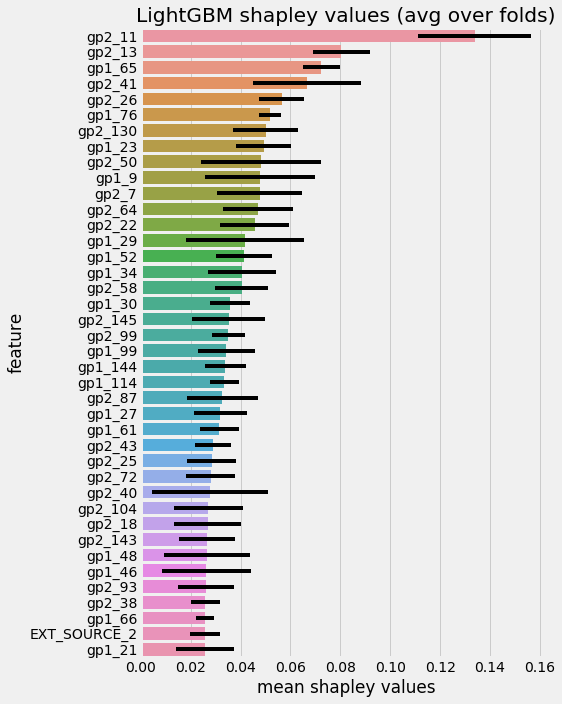

Running Kfold - done in 362s


In [31]:
with timer('Running Kfold'):
    pred_8, feat_8, roc_8 = kfold_lightgbm(train_df_8[feats], train_df_target_8, test_df[feats], num_folds=5, flag_8=True)
    gc.collect()

In [32]:
percentile = 0.22 ## tweak me
best_features_8 = feat_8[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean']).sort_values(by="mean", ascending=False).reset_index()

## Using 200 features = ['gp2_11' 'gp2_13' 'gp1_65' 'gp2_41' 'gp2_26' 'gp1_76' 'gp2_130' 'gp1_23'
 'gp2_50' 'gp1_9' 'gp2_7' 'gp2_64' 'gp2_22' 'gp1_29' 'gp1_52' 'gp1_34'
 'gp2_58' 'gp1_30' 'gp2_145' 'gp2_99' 'gp1_99' 'gp1_144' 'gp1_114'
 'gp2_87' 'gp1_27' 'gp1_61' 'gp2_43' 'gp2_25' 'gp2_72' 'gp2_40' 'gp2_104'
 'gp2_18' 'gp2_143' 'gp1_48' 'gp1_46' 'gp2_93' 'gp2_38' 'gp1_66'
 'EXT_SOURCE_2' 'gp1_21' 'gp2_107' 'gp1_42' 'gp2_77' 'gp1_70' 'gp2_19'
 'gp1_50' 'gp1_20' 'gp1_25' 'gp1_37' 'gp2_48' 'gp1_13' 'gp1_103' 'gp2_100'
 'gp2_65' 'gp2_29' 'gp1_108' 'gp1_19' 'INSTAL_DPD_MEAN' 'gp1_74' 'gp2_84'
 'gp1_81' 'gp1_69' 'gp1_145' 'gp1_67' 'gp1_32' 'gp2_12' 'gp2_113' 'gp2_63'
 'gp2_116' 'NEW_CREDIT_TO_ANNUITY_RATIO' 'gp2_67' 'gp2_132' 'gp2_53'
 'gp1_26' 'gp2_45' 'gp2_69' 'gp1_38' 'gp2_35' 'gp1_85' 'gp2_80' 'gp2_126'
 'NEW_SCORES_STD' 'gp1_41' 'gp1_63' 'gp2_76' 'gp2_52' 'gp1_87' 'gp1_117'
 'gp2_46' 'gp1_79' 'gp1_55' 'gp2_60' 'gp1_43' 'gp1_111' 'gp2_32' 'gp2_34'
 'gp2_74' 'gp1_1' 'gp2_17' 'gp2_30' 'gp2

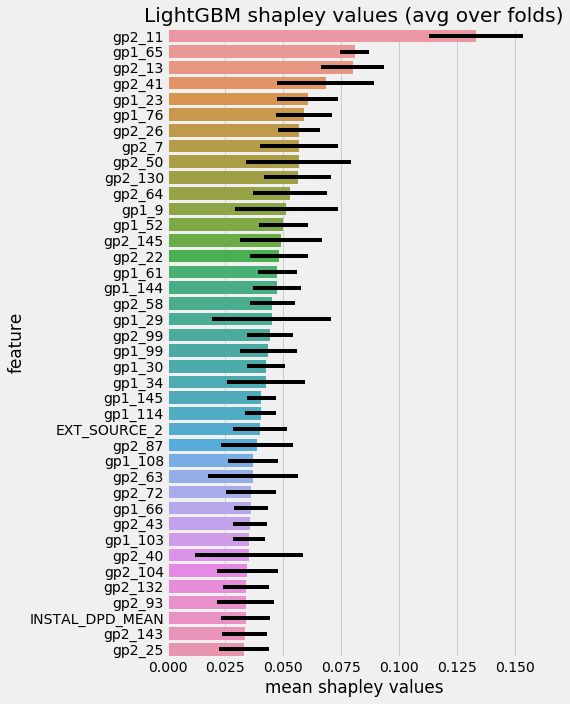

Run LightGBM with kfold - done in 132s


In [33]:
best_features_8 = best_features_8[:200]["feature"].values
#best_features = best_features[best_features['mean']>0]['feature'].values
print("## Using {} features =".format(len(best_features_8)), best_features_8)
with timer("Run LightGBM with kfold"):
    pred_8, feat_8, roc_8 = kfold_lightgbm(train_df_8[best_features_8], train_df_target_8, test_df[best_features_8], num_folds=5, stratified=False)
    gc.collect()

In [34]:
del train_df_8, train_df_target_8
test_df['TARGET'] = pred_8

In [35]:
test_df[['SK_ID_CURR','TARGET']].to_csv('8_gp_submission.csv', index=False)

In [ ]:
create_download_link(test_df[['SK_ID_CURR','TARGET']])